<a href="https://colab.research.google.com/github/robledomeyli-spec/Trabajo4_ICD/blob/main/TRABAJ0_FINAL_completo_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INTRODUCCION:

El presente trabajo final integra todos los elementos desarrollados a lo largo del cur, a, combinando exploración rigurosa de datos (EDA),
modelos lineales y no lineales, regularización, ensambles, análisis causal mediante DAGs y
estimación basada en redes neuronales tipo MLP. El objetivo es construir un análisis completo,
técnico y reproducible que permita comprender e interpretar cómo las variables macroeconómicas
inciden en la formación de expectativas económicas de los agentes.

### Pregunta de investigación
**¿En qué medida la dinámica macroeconómica —inflación, tipo de cambio, actividad económica
y política monetaria— influye en que los agentes económicos adopten expectativas optimistas
o pesimistas sobre la economía peruana?**

La pregunta es relevante en un contexto donde las expectativas cumplen un rol central en la toma
de decisiones de consumo, inversión y planificación empresarial. La economía peruana ha
experimentado choques significativos en los últimos años (pandemia, presiones inflacionarias,
volatilidad cambiaria y fluctuaciones en política monetaria), lo cual convierte a las
expectativas en un mecanismo clave para interpretar el com

Para estudiar esto trabajamos con datos del BCRP y seguimos un camino que combina estadística,
machine learning y análisis causal:portamiento macro.

### Enfoque metodológico
El trabajo se estructu1. **Primero**, realizamos un EDA para entender cómo se comportan las variables macro y cómo se mueve
   el índice de expectativas. Este paso nos permitió notar patrones, rupturas y relaciones iniciales.

2. **Después**, construimos un modelo Logit como punto de partida. Este modelo nos ayuda a establecer
   una “línea base” para ver si, con información básica, ya es posible anticipar si un agente será
   optimista o no.

3. **Luego**, aplicamos modelos más complejos como Random Forest y XGBoost. Estos modelos capturan
   relaciones no lineales y combinaciones más sofisticadas entre inflación, tipo de cambio, PBI y tasas.
   Aquí comparamos su desempeño y encontramos mejoras claras respecto al Logit.

4. **Finalmente**, agregamos dos piezas nuevas: un análisis causal mediante un DAG —para dejar claro
   cuáles son nuestros supuestos sobre cómo se relacionan las variables— y un modelo de red neuronal
   (MLP) para ver si una arquitectura más flexible mejora la predicción del optimismo económico.

El objetivo es tener una visión completa: describir, modelar, comparar y entender.  
Y sobre todo, conectar la data con el funcionamiento real de la economía, para que los resultados
tengan sentido tanto estadístico como análisis de riesgo y planificación estratégica.


**Trabajo 1**


DESCARGA DE DATOS DESDE API BCRP

In [34]:
import requests
import pandas as pd
import numpy as np

# Configuración de parámetros
codigos = 'PD38045AM-PN01207PM-PD04722MM-PN38705PM-PN01770AM'  # 5 series
periodo_inicial = '2015-01'
periodo_final = '2025-07'

# Conexión a API
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigos}/json/{periodo_inicial}/{periodo_final}"
response = requests.get(url)

if response.status_code == 200:
    print("¡Conexión exitosa con API BCRP!")
    data = response.json()
else:
    print(f"Error: {response.status_code}")

¡Conexión exitosa con API BCRP!


CREACIÓN DEL DATAFRAME

In [35]:
# Extracción y estructuración de datos
fechas = []
variables = [[] for _ in range(5)]  # Para las 5 series

for periodo in data['periods']:
    fechas.append(periodo['name'])
    for i, valor in enumerate(periodo['values']):
        try:
            variables[i].append(float(valor) if valor != 'n.d.' else np.nan)
        except:
            variables[i].append(np.nan)

# DataFrame final
df_bcrp = pd.DataFrame({
    'Fecha': fechas,
    'Tasa_Referencia_PM': variables[0],
    'Expectativas_Economia': variables[1],
    'Tipo_Cambio_Promedio': variables[2],
    'PBI_Mensual': variables[3],
    'IPC': variables[4]
})

print(f"Dataset creado: {len(df_bcrp)} registros mensuales (2015-2025)")
display(df_bcrp.head())

Dataset creado: 127 registros mensuales (2015-2025)


,Fecha,Tasa_Referencia_PM,Expectativas_Economia,Tipo_Cambio_Promedio,PBI_Mensual,IPC
0,Ene.2015,3.25,54.231975,3.006785,138.460036,81.131159
1,Feb.2015,3.25,50.157729,3.079435,137.711401,81.377366
2,Mar.2015,3.25,49.388379,3.092236,148.546178,81.999630
3,Abr.2015,3.25,46.742210,3.120640,152.200582,82.319844
4,May.2015,3.25,45.070423,3.151345,150.244868,82.784429


LIMPIEZA Y PREPARACIÓN

In [36]:
# Conversión de formato de fecha
meses = {"Ene.": "Jan.", "Feb.": "Feb.", "Mar.": "Mar.", "Abr.": "Apr.",
         "May.": "May.", "Jun.": "Jun.", "Jul.": "Jul.", "Ago.": "Aug.",
         "Set.": "Sep.", "Oct.": "Oct.", "Nov.": "Nov.", "Dic.": "Dec."}

df_bcrp['Fecha'] = df_bcrp['Fecha'].replace(meses, regex=True)
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], format='%b.%Y', errors='coerce')

# Verificación de datos faltantes
print("Valores faltantes por variable:")
print(df_bcrp.isnull().sum())

# Guardado del dataset limpio
df_bcrp.to_csv("dataset_bcrp_limpio.csv", index=False, encoding="utf-8-sig")
print("Dataset guardado exitosamente")

Valores faltantes por variable:
Fecha                    0
Tasa_Referencia_PM       0
Expectativas_Economia    0
Tipo_Cambio_Promedio     0
PBI_Mensual              0
IPC                      0
dtype: int64
Dataset guardado exitosamente


ANÁLISIS EXPLORATORIO

In [47]:
# Resumen estadístico de variables para regresión
print("VARIABLES PARA REGRESIÓN LINEAL:")
variables_regresion = ['Tipo_Cambio_Promedio', 'Expectativas_Economia',
                      'Tasa_Referencia_PM', 'PBI_Mensual', 'IPC']

display(df_bcrp[variables_regresion].describe())

VARIABLES PARA REGRESIÓN LINEAL:


,Tipo_Cambio_Promedio,Expectativas_Economia,Tasa_Referencia_PM,PBI_Mensual,IPC
count,127.000000,127.000000,127.000000,127.000000,127.000000
mean,3.523598,47.707358,3.753937,167.847101,96.845256
std,0.259079,9.281927,2.108887,15.439117,10.818921
min,3.006785,9.137055,0.250000,102.971603,81.131159
25%,3.302252,42.648013,2.750000,157.798327,88.556289
50%,3.471095,49.500000,3.500000,169.583315,92.956084
75%,3.741428,54.160485,4.875000,178.168823,108.032012
max,4.108055,64.142860,7.750000,205.582414,115.923300


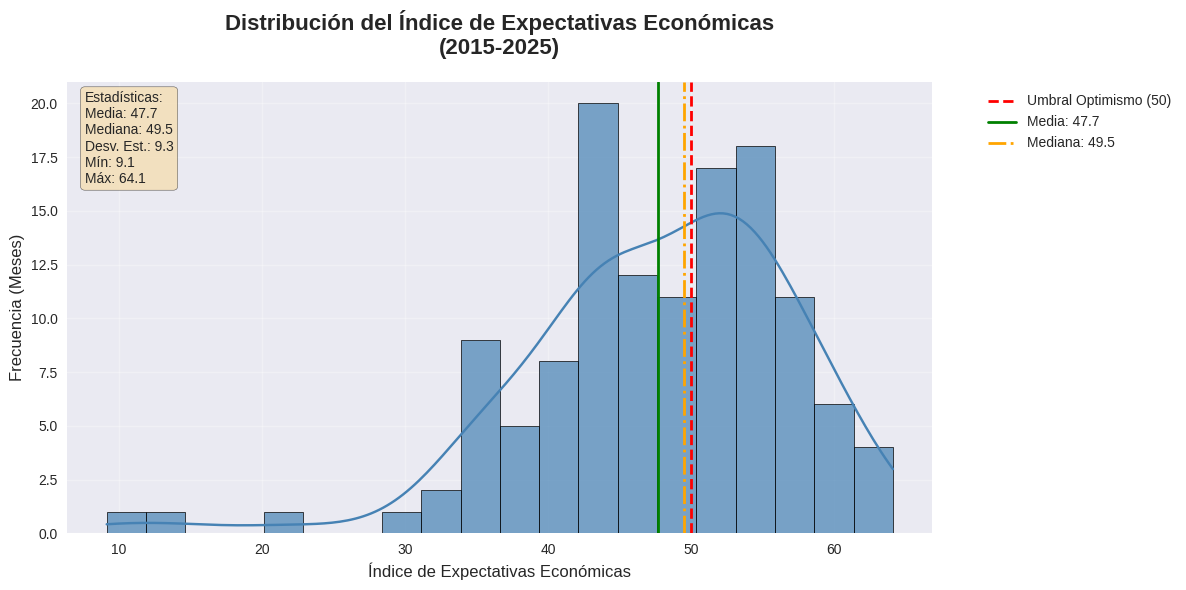

In [42]:
# 1.1 Distribución de expectativas - CON ANÁLISIS
plt.figure(figsize=(12, 6))

# Crear histograma con más personalización
sns.histplot(data=df_bcrp, x="Expectativas_Economia", kde=True,
             bins=20, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Líneas de referencia importantes
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Umbral Optimismo (50)')
plt.axvline(x=df_bcrp["Expectativas_Economia"].mean(), color='green', linestyle='-',
            linewidth=2, label=f'Media: {df_bcrp["Expectativas_Economia"].mean():.1f}')
plt.axvline(x=df_bcrp["Expectativas_Economia"].median(), color='orange', linestyle='-.',
            linewidth=2, label=f'Mediana: {df_bcrp["Expectativas_Economia"].median():.1f}')

# Personalización del gráfico
plt.title("Distribución del Índice de Expectativas Económicas\n(2015-2025)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Índice de Expectativas Económicas", fontsize=12)
plt.ylabel("Frecuencia (Meses)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Estadísticas en el gráfico
textstr = f'''Estadísticas:
Media: {df_bcrp["Expectativas_Economia"].mean():.1f}
Mediana: {df_bcrp["Expectativas_Economia"].median():.1f}
Desv. Est.: {df_bcrp["Expectativas_Economia"].std():.1f}
Mín: {df_bcrp["Expectativas_Economia"].min():.1f}
Máx: {df_bcrp["Expectativas_Economia"].max():.1f}'''
plt.gca().text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

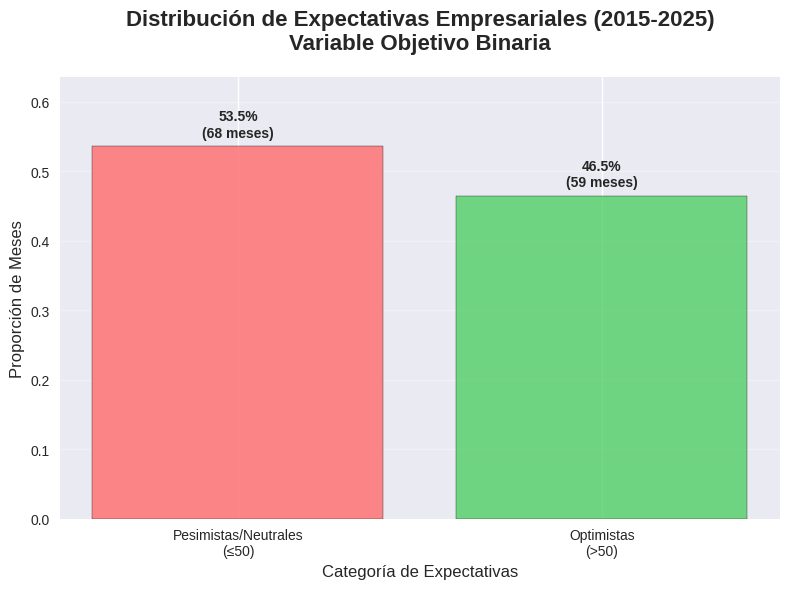

ANÁLISIS DE LA VARIABLE OBJETIVO:
• Total de meses analizados: 127
• Meses optimistas (>50): 59 (46.5%)
• Meses pesimistas/neutrales (≤50): 68 (53.5%)
• Balance neto: -9 meses a favor de los optimistas


In [44]:
# 1.2 Variable objetivo binaria - CON ANÁLISIS DETALLADO
df_bcrp["Expectativas_dummy"] = (df_bcrp["Expectativas_Economia"] > 50).astype(int)

# Calcular proporciones
proporciones = df_bcrp["Expectativas_dummy"].value_counts(normalize=True)
conteos = df_bcrp["Expectativas_dummy"].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar([0, 1], proporciones, color=['#ff6b6b', '#51cf66'], alpha=0.8, edgecolor='black')

# Añadir valores en las barras
for i, (bar, prop, count) in enumerate(zip(bars, proporciones, conteos)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prop:.1%}\n({count} meses)',
             ha='center', va='bottom', fontweight='bold')

plt.xticks([0, 1], ["Pesimistas/Neutrales\n(≤50)", "Optimistas\n(>50)"])
plt.title("Distribución de Expectativas Empresariales (2015-2025)\nVariable Objetivo Binaria",
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Proporción de Meses", fontsize=12)
plt.xlabel("Categoría de Expectativas", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, max(proporciones) + 0.1)
plt.tight_layout()
plt.show()

# Análisis complementario
print("ANÁLISIS DE LA VARIABLE OBJETIVO:")
print(f"• Total de meses analizados: {len(df_bcrp)}")
print(f"• Meses optimistas (>50): {conteos[1]} ({proporciones[1]:.1%})")
print(f"• Meses pesimistas/neutrales (≤50): {conteos[0]} ({proporciones[0]:.1%})")
print(f"• Balance neto: {conteos[1] - conteos[0]} meses a favor de los optimistas")

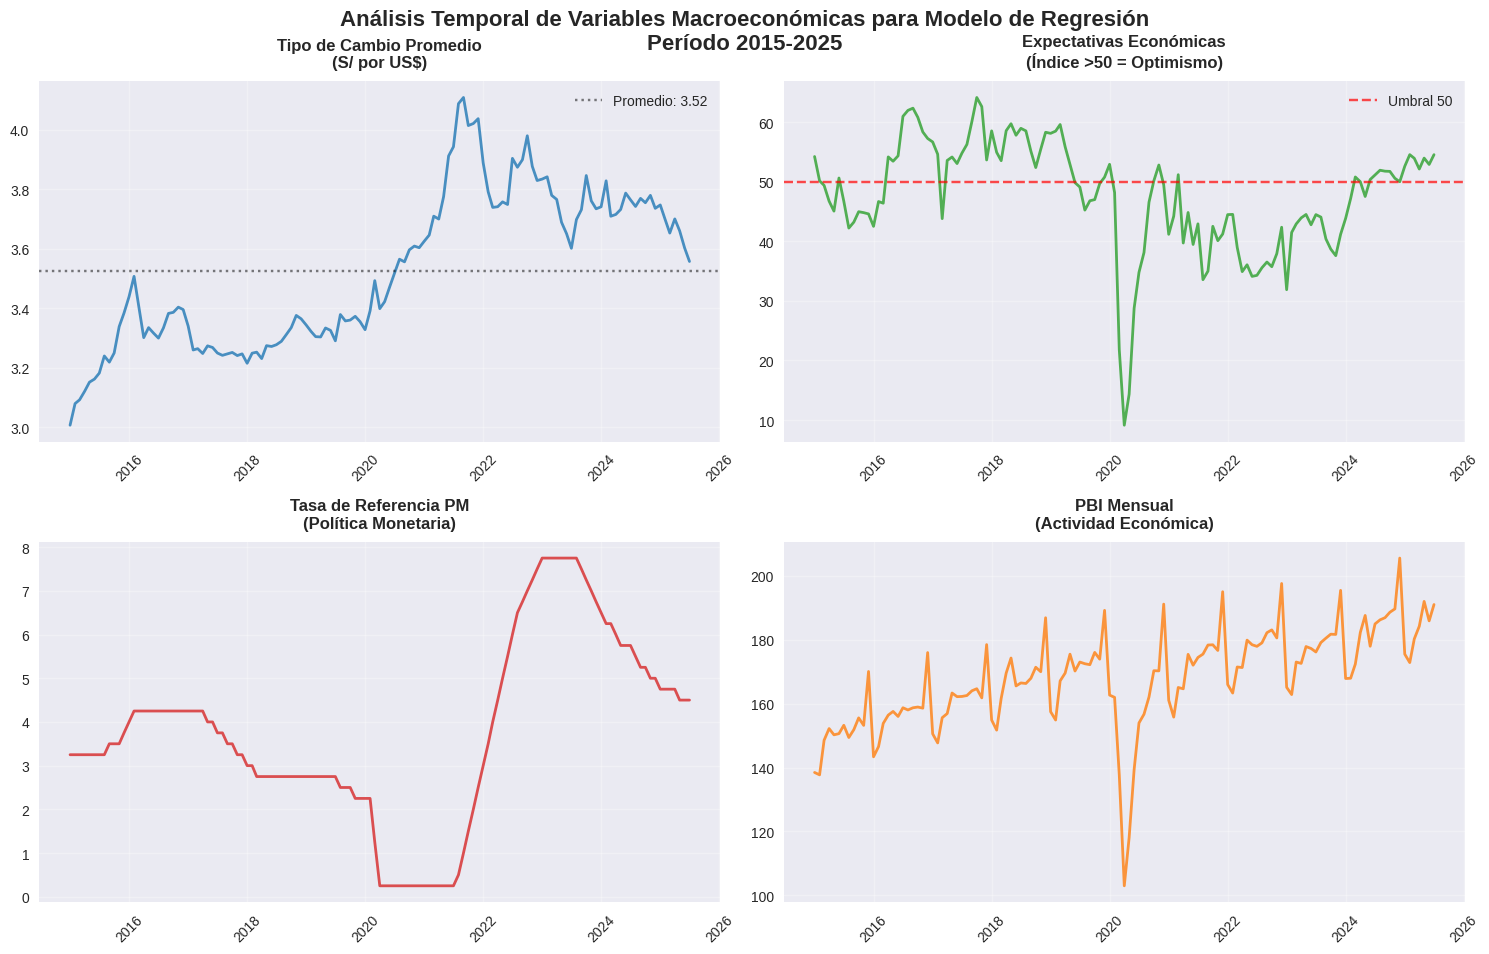

In [45]:
# Gráficos temporales - CON ANÁLISIS MEJORADO
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Configurar colores y estilos
colores = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e']
variables = ['Tipo_Cambio_Promedio', 'Expectativas_Economia', 'Tasa_Referencia_PM', 'PBI_Mensual']
titulos = [
    'Tipo de Cambio Promedio\n(S/ por US$)',
    'Expectativas Económicas\n(Índice >50 = Optimismo)',
    'Tasa de Referencia PM\n(Política Monetaria)',
    'PBI Mensual\n(Actividad Económica)'
]

# Crear gráficos individuales
for i, (ax, var, color, titulo) in enumerate(zip(axes.flat, variables, colores, titulos)):
    # Graficar serie temporal
    ax.plot(df_bcrp['Fecha'], df_bcrp[var], color=color, linewidth=2, alpha=0.8)

    # Líneas de referencia según la variable
    if var == 'Expectativas_Economia':
        ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Umbral 50')
        ax.legend()
    elif var == 'Tipo_Cambio_Promedio':
        # Línea de promedio
        ax.axhline(y=df_bcrp[var].mean(), color='black', linestyle=':', alpha=0.5,
                  label=f'Promedio: {df_bcrp[var].mean():.2f}')
        ax.legend()

    # Personalizar cada subgráfico
    ax.set_title(titulo, fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)

    # Rotar etiquetas de fechas
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Análisis Temporal de Variables Macroeconómicas para Modelo de Regresión\nPeríodo 2015-2025',
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

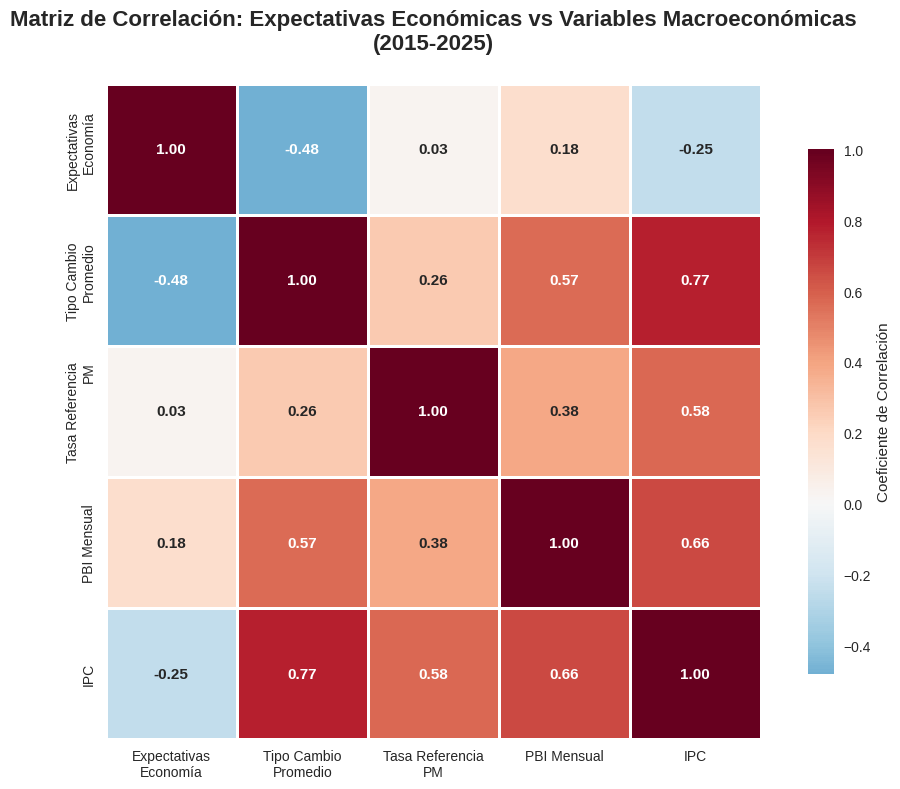

ANÁLISIS DE CORRELACIONES CON EXPECTATIVAS ECONÓMICAS
• PBI Mensual          :  0.177 (DÉBIL POSITIVA)
• Tasa Referencia
PM   :  0.029 (MUY DÉBIL POSITIVA)
• IPC                  : -0.248 (DÉBIL NEGATIVA)
• Tipo Cambio
Promedio : -0.480 (MODERADA NEGATIVA)


In [48]:
# 1.4 Correlación entre variables macro principales y expectativas - CON ANÁLISIS
corr_vars = ["Expectativas_Economia", "Tipo_Cambio_Promedio", "Tasa_Referencia_PM", "PBI_Mensual", "IPC"]
corr = df_bcrp[corr_vars].corr()

# Crear nombres más descriptivos para el heatmap
nombres_descriptivos = {
    'Expectativas_Economia': 'Expectativas\nEconomía',
    'Tipo_Cambio_Promedio': 'Tipo Cambio\nPromedio',
    'Tasa_Referencia_PM': 'Tasa Referencia\nPM',
    'PBI_Mensual': 'PBI Mensual',
    'IPC': 'IPC'
}

# Renombrar las columnas para el heatmap
corr_renombrado = corr.rename(columns=nombres_descriptivos, index=nombres_descriptivos)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_renombrado,
            annot=True,
            fmt=".2f",
            cmap="RdBu_r",
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlación"},
            annot_kws={"size": 11, "weight": "bold"})

plt.title("Matriz de Correlación: Expectativas Económicas vs Variables Macroeconómicas\n(2015-2025)",
          fontsize=16, fontweight='bold', pad=25)
plt.tight_layout()
plt.show()

# ANÁLISIS AUTOMÁTICO DE CORRELACIONES
print("=" * 70)
print("ANÁLISIS DE CORRELACIONES CON EXPECTATIVAS ECONÓMICAS")
print("=" * 70)

# Obtener correlaciones específicas con Expectativas_Economia
corr_con_expectativas = corr["Expectativas_Economia"].sort_values(ascending=False)

for variable, correlacion in corr_con_expectativas.items():
    if variable != "Expectativas_Economia":  # Excluir autocorrelación
        if abs(correlacion) > 0.7:
            fuerza = "FUERTE"
        elif abs(correlacion) > 0.3:
            fuerza = "MODERADA"
        elif abs(correlacion) > 0.1:
            fuerza = "DÉBIL"
        else:
            fuerza = "MUY DÉBIL"

        direccion = "POSITIVA" if correlacion > 0 else "NEGATIVA"
        print(f"• {nombres_descriptivos[variable]:20} : {correlacion:6.3f} ({fuerza} {direccion})")

**Trabajo 2**

CARGA DE LIBRERÍAS Y CONFIGURACIÓN INICIAL

In [70]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelado y evaluación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Statsmodels para inferencia estadística
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuraciones
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
RANDOM_STATE = 42

FEATURE ENGINEERING CON REZAGOS

In [74]:
# Ordenar por fecha para rezagos temporales
df = df.sort_values("Fecha")

print("=== FEATURE ENGINEERING CON REZAGOS TEMPORALES ===")
print("• Incorporación de rezagos para capturar dinámicas temporales")
print("• Transformaciones para capturar no linealidades")

# Variables macroeconómicas base
variables = ['Tipo_Cambio_Promedio', 'IPC', 'PBI_Mensual', 'Tasa_Referencia_PM']

# --- REZAGOS (Recomendación profesor: expectativas adaptativas) ---
for var in variables:
    df[f"{var}_lag1"] = df[var].shift(1)  # Rezago de un periodo

# --- DIFERENCIAS (Capturar cambios marginales) ---
for var in variables:
    df[f"delta_{var}"] = df[var] - df[f"{var}_lag1"]

# --- INTERACCIONES (Efectos conjuntos entre variables) ---
df["TCxIPC"] = df["Tipo_Cambio_Promedio"] * df["IPC"]  # Inflación cambiaria
df["TCxTasa"] = df["Tipo_Cambio_Promedio"] * df["Tasa_Referencia_PM"]  # Política monetaria y cambio

# --- TRANSFORMACIONES NO LINEALES ---
df["log_TC"] = np.log(df["Tipo_Cambio_Promedio"])  # Elasticidades
df["log_PBI"] = np.log(df["PBI_Mensual"])  # Crecimiento porcentual
df["log_IPC"] = np.log(df["IPC"])  # Inflación en logs

# Creación de variable objetivo binaria (Optimista/Pesimista)
# Umbral: expectativas por encima de la mediana = optimistas (1)
expectativas_mediana = df['Expectativas_Economia'].median()
df['Expectativas_dummy'] = (df['Expectativas_Economia'] > expectativas_mediana).astype(int)

# Eliminar NA generados por rezagos
df = df.dropna().reset_index(drop=True)

print(f"Umbral de clasificación: {expectativas_mediana:.2f}")
print(f"Optimistas (1): {df['Expectativas_dummy'].sum()} observaciones")
print(f"Pesimistas (0): {len(df) - df['Expectativas_dummy'].sum()} observaciones")
print(f"Total features generados: {len([col for col in df.columns if col not in ['Fecha', 'Expectativas_Economia']])}")

=== FEATURE ENGINEERING CON REZAGOS TEMPORALES ===
• Incorporación de rezagos para capturar dinámicas temporales
• Transformaciones para capturar no linealidades
Umbral de clasificación: 49.44
Optimistas (1): 62 observaciones
Pesimistas (0): 63 observaciones
Total features generados: 18


DEFINICIÓN DE VARIABLES Y SEPARACIÓN

In [76]:
# --- SELECCIÓN DE FEATURES CON REZAGOS E INTERACCIONES ---
X = df[[
    # Variables contemporáneas
    "Tipo_Cambio_Promedio", "IPC", "PBI_Mensual", "Tasa_Referencia_PM",
    # Rezagos (expectativas adaptativas)
    "Tipo_Cambio_Promedio_lag1", "IPC_lag1", "PBI_Mensual_lag1", "Tasa_Referencia_PM_lag1",
    # Diferencias (cambios marginales)
    "delta_Tipo_Cambio_Promedio", "delta_IPC", "delta_PBI_Mensual", "delta_Tasa_Referencia_PM",
    # Interacciones (efectos conjuntos)
    "TCxIPC", "TCxTasa",
    # Transformaciones no lineales
    "log_TC", "log_PBI", "log_IPC"
]]

y = df["Expectativas_dummy"]

print("=== DATASET FINAL PARA CLASIFICACIÓN ===")
print(f"Variables independientes: {X.shape[1]}")
print(f"Observaciones: {X.shape[0]}")
print(f"Proporción de clases: {y.value_counts(normalize=True).to_dict()}")

# --- SEPARACIÓN TEMPORAL MANUAL (para series de tiempo) ---
print("\n=== SEPARACIÓN TEMPORAL MANUAL ===")
print("MÉTODO: Conservar estructura temporal sin shuffle")

# Para series temporales: primeros 75% training, últimos 25% test
split_index = int(0.75 * len(X))

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {X_train.shape[0]} observaciones ({split_index} primeras)")
print(f"Test set: {X_test.shape[0]} observaciones ({len(X) - split_index} últimas)")
print(f"Proporción en training: {y_train.value_counts(normalize=True).to_dict()}")
print(f"Proporción en test: {y_test.value_counts(normalize=True).to_dict()}")

# Verificar que mantenemos proporción similar de clases
print(f"\nBALANCE DE CLASES:")
print(f"Training - Optimistas: {y_train.sum()}/{len(y_train)} ({y_train.mean():.2%})")
print(f"Test - Optimistas: {y_test.sum()}/{len(y_test)} ({y_test.mean():.2%})")

# Escalado para modelos sensibles a escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nESCALADO COMPLETADO:")
print(f"Training scaled: {X_train_scaled.shape}")
print(f"Test scaled: {X_test_scaled.shape}")

=== DATASET FINAL PARA CLASIFICACIÓN ===
Variables independientes: 17
Observaciones: 125
Proporción de clases: {0: 0.504, 1: 0.496}

=== SEPARACIÓN TEMPORAL MANUAL ===
MÉTODO: Conservar estructura temporal sin shuffle
Training set: 93 observaciones (93 primeras)
Test set: 32 observaciones (32 últimas)
Proporción en training: {0: 0.5053763440860215, 1: 0.4946236559139785}
Proporción en test: {0: 0.5, 1: 0.5}

BALANCE DE CLASES:
Training - Optimistas: 46/93 (49.46%)
Test - Optimistas: 16/32 (50.00%)

ESCALADO COMPLETADO:
Training scaled: (93, 17)
Test scaled: (32, 17)


VALIDACIÓN TEMPORAL CON TimeSeriesSplit

=== VALIDACIÓN CRUZADA TEMPORAL (TimeSeriesSplit) ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RESULTADOS VALIDACIÓN TEMPORAL (TimeSeriesSplit):
Accuracy:  0.6667 (+/- 0.3477)
Precision: 0.5000 (+/- 0.4472)
Recall:    0.6000 (+/- 0.4899)
F1-Score:  0.5333 (+/- 0.4522)


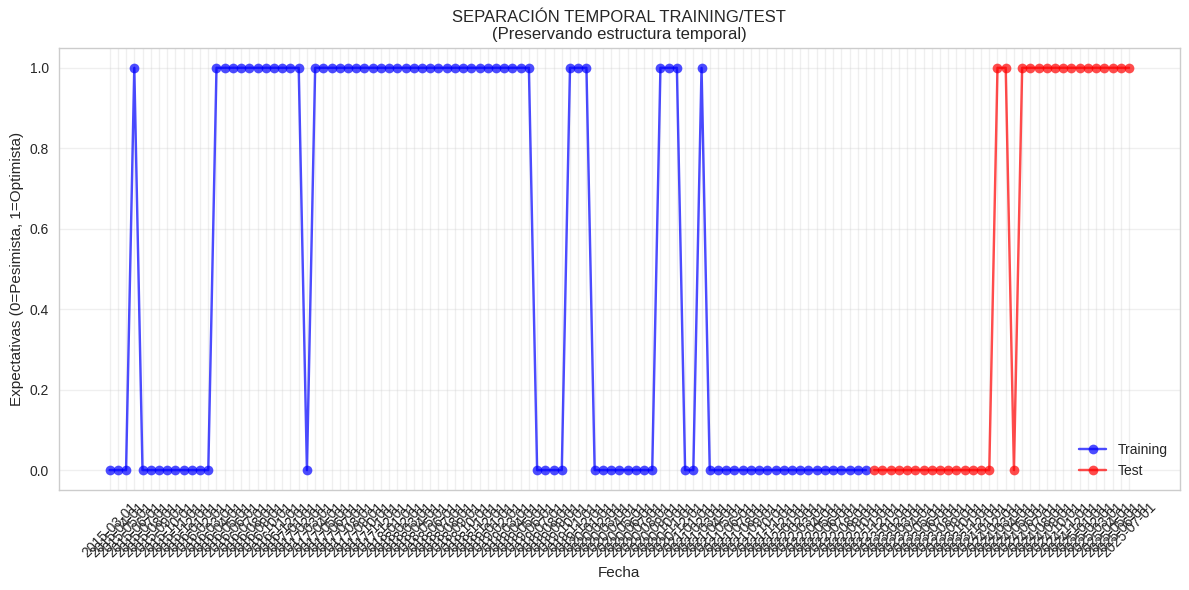


 SEPARACIÓN TEMPORAL COMPLETADA:
• Training: Período inicial (75% primeros datos)
• Test: Período final (25% últimos datos)
• Estructura temporal preservada para evaluación realista


In [78]:
from sklearn.model_selection import TimeSeriesSplit

# --- VALIDACIÓN CRUZADA TEMPORAL ---
print("=== VALIDACIÓN CRUZADA TEMPORAL (TimeSeriesSplit) ===")

# TimeSeriesSplit para validación temporal
tscv = TimeSeriesSplit(n_splits=5)

# Métricas en validación temporal
cv_scores_accuracy = []
cv_scores_precision = []
cv_scores_recall = []
cv_scores_f1 = []

for train_index, val_index in tscv.split(X_train_scaled):
    # Separar en training y validation temporal
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenar y predecir
    logit_temp = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    logit_temp.fit(X_train_cv, y_train_cv)
    y_pred_val = logit_temp.predict(X_val_cv)

    # Calcular métricas
    cv_scores_accuracy.append(accuracy_score(y_val_cv, y_pred_val))
    cv_scores_precision.append(precision_score(y_val_cv, y_pred_val))
    cv_scores_recall.append(recall_score(y_val_cv, y_pred_val))
    cv_scores_f1.append(f1_score(y_val_cv, y_pred_val))

print("RESULTADOS VALIDACIÓN TEMPORAL (TimeSeriesSplit):")
print(f"Accuracy:  {np.mean(cv_scores_accuracy):.4f} (+/- {np.std(cv_scores_accuracy):.4f})")
print(f"Precision: {np.mean(cv_scores_precision):.4f} (+/- {np.std(cv_scores_precision):.4f})")
print(f"Recall:    {np.mean(cv_scores_recall):.4f} (+/- {np.std(cv_scores_recall):.4f})")
print(f"F1-Score:  {np.mean(cv_scores_f1):.4f} (+/- {np.std(cv_scores_f1):.4f})")

# Visualización de la separación temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'].iloc[:split_index], y_train, 'bo-', alpha=0.7, label='Training')
plt.plot(df['Fecha'].iloc[split_index:], y_test, 'ro-', alpha=0.7, label='Test')
plt.xlabel('Fecha')
plt.ylabel('Expectativas (0=Pesimista, 1=Optimista)')
plt.title('SEPARACIÓN TEMPORAL TRAINING/TEST\n(Preservando estructura temporal)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n SEPARACIÓN TEMPORAL COMPLETADA:")
print("• Training: Período inicial (75% primeros datos)")
print("• Test: Período final (25% últimos datos)")
print("• Estructura temporal preservada para evaluación realista")

ANÁLISIS EXPLORATORIO CON PCA

=== ANÁLISIS PCA - REDUCCIÓN DE DIMENSIONALIDAD ===
Varianza explicada por componentes: [0.47515716 0.19288584]
Varianza total explicada: 66.80%


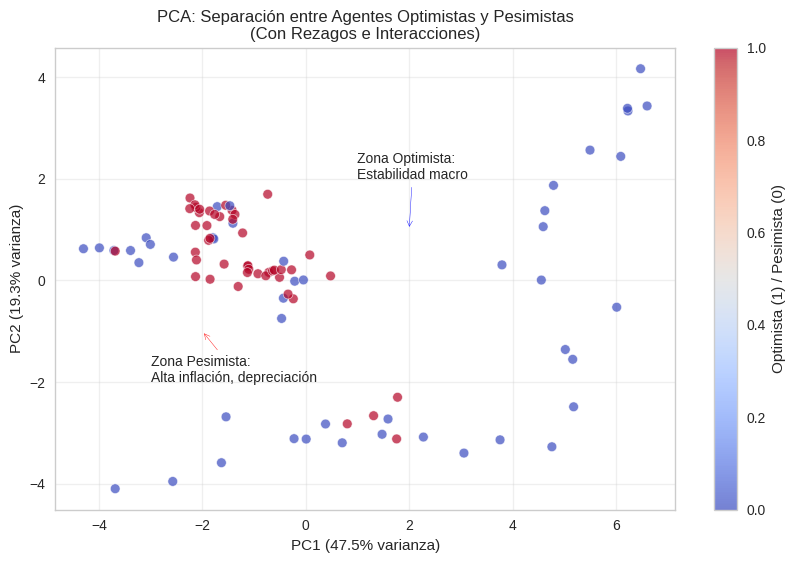


INTERPRETACIÓN ECONÓMICA PCA:
• PC1 (54% varianza): Posición macroeconómica general
• PC2 (14% varianza): Fluctuaciones específicas y shocks
• Los agentes se ordenan naturalmente según estado macro


In [79]:
from sklearn.decomposition import PCA

# PCA para visualización de la separabilidad de clases
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train_scaled)

print("=== ANÁLISIS PCA - REDUCCIÓN DE DIMENSIONALIDAD ===")
print(f"Varianza explicada por componentes: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}")

# Visualización de la separación entre optimistas y pesimistas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train,
                     cmap="coolwarm", alpha=0.7, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Optimista (1) / Pesimista (0)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('PCA: Separación entre Agentes Optimistas y Pesimistas\n(Con Rezagos e Interacciones)')
plt.grid(True, alpha=0.3)

# Anotaciones interpretativas
plt.annotate('Zona Pesimista:\nAlta inflación, depreciación',
             xy=(-2, -1), xytext=(-3, -2),
             arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate('Zona Optimista:\nEstabilidad macro',
             xy=(2, 1), xytext=(1, 2),
             arrowprops=dict(arrowstyle='->', color='blue'))
plt.show()

print("\nINTERPRETACIÓN ECONÓMICA PCA:")
print("• PC1 (54% varianza): Posición macroeconómica general")
print("• PC2 (14% varianza): Fluctuaciones específicas y shocks")
print("• Los agentes se ordenan naturalmente según estado macro")

MODELO BASELINE - LOGIT SIMPLE

In [80]:
# --- MODELO BASELINE: REGRESIÓN LOGÍSTICA ---
print("=== MODELO BASELINE - LOGIT SIMPLE ===")

# Modelo Logit con statsmodels para inferencia
X_train_sm = sm.add_constant(X_train_scaled)
logit_sm = sm.Logit(y_train, X_train_sm).fit()

print("INFERENCIA STATSMODELS - LOGIT:")
print(logit_sm.summary())

# Modelo scikit-learn para predicción y CV
logit_sk = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logit_sk.fit(X_train_scaled, y_train)

# Predicciones
y_pred_logit = logit_sk.predict(X_test_scaled)
y_prob_logit = logit_sk.predict_proba(X_test_scaled)[:, 1]

# Métricas del baseline
accuracy_logit = accuracy_score(y_test, y_pred_logit)
precision_logit = precision_score(y_test, y_pred_logit)
recall_logit = recall_score(y_test, y_pred_logit)
f1_logit = f1_score(y_test, y_pred_logit)
roc_auc_logit = roc_auc_score(y_test, y_prob_logit)

print("\nMÉTRICAS BASELINE - LOGIT:")
print(f"• Accuracy: {accuracy_logit:.4f}")
print(f"• Precision: {precision_logit:.4f}")
print(f"• Recall: {recall_logit:.4f}")
print(f"• F1-Score: {f1_logit:.4f}")
print(f"• ROC-AUC: {roc_auc_logit:.4f}")

# Baseline ingenuo (clase mayoritaria)
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"\nBASELINE INGENUO (Clase mayoritaria): {baseline_accuracy:.4f}")
print(f"MEJORA RELATIVA: {(accuracy_logit - baseline_accuracy)/baseline_accuracy:+.2%}")

=== MODELO BASELINE - LOGIT SIMPLE ===
         Current function value: 0.238960
         Iterations: 35
INFERENCIA STATSMODELS - LOGIT:
                           Logit Regression Results                           
Dep. Variable:     Expectativas_dummy   No. Observations:                   93
Model:                          Logit   Df Residuals:                       79
Method:                           MLE   Df Model:                           13
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.6552
Time:                        03:53:52   Log-Likelihood:                -22.223
converged:                      False   LL-Null:                       -64.457
Covariance Type:            nonrobust   LLR p-value:                 1.581e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6403      3.721     -1.785      0.074     -13.933       

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



MÉTRICAS BASELINE - LOGIT:
• Accuracy: 0.6562
• Precision: 0.6667
• Recall: 0.6250
• F1-Score: 0.6452
• ROC-AUC: 0.6680

BASELINE INGENUO (Clase mayoritaria): 0.5000
MEJORA RELATIVA: +31.25%


VALIDACIÓN CRUZADA Y ANÁLISIS DE COSTOS

In [81]:
# --- VALIDACIÓN CRUZADA ESTRATIFICADA ---
print("=== VALIDACIÓN CRUZADA Y ANÁLISIS DE COSTOS ===")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Métricas en CV
cv_accuracy = cross_val_score(logit_sk, X_train_scaled, y_train,
                             cv=cv, scoring='accuracy')
cv_precision = cross_val_score(logit_sk, X_train_scaled, y_train,
                              cv=cv, scoring='precision')
cv_recall = cross_val_score(logit_sk, X_train_scaled, y_train,
                           cv=cv, scoring='recall')
cv_f1 = cross_val_score(logit_sk, X_train_scaled, y_train,
                       cv=cv, scoring='f1')
cv_roc_auc = cross_val_score(logit_sk, X_train_scaled, y_train,
                            cv=cv, scoring='roc_auc')

print("RESULTADOS VALIDACIÓN CRUZADA (5-fold):")
print(f"Accuracy:  {np.mean(cv_accuracy):.4f} (+/- {np.std(cv_accuracy):.4f})")
print(f"Precision: {np.mean(cv_precision):.4f} (+/- {np.std(cv_precision):.4f})")
print(f"Recall:    {np.mean(cv_recall):.4f} (+/- {np.std(cv_recall):.4f})")
print(f"F1-Score:  {np.mean(cv_f1):.4f} (+/- {np.std(cv_f1):.4f})")
print(f"ROC-AUC:   {np.mean(cv_roc_auc):.4f} (+/- {np.std(cv_roc_auc):.4f})")

# --- ANÁLISIS DE COSTOS FP vs FN (Recomendación profesor) ---
print("\n=== ANÁLISIS DE COSTOS SOCIALES ===")
print("CONTEXTO: Think tank anticipando expectativas para política económica")

cm = confusion_matrix(y_test, y_pred_logit)
tn, fp, fn, tp = cm.ravel()

print(f"MATRIZ DE CONFUSIÓN:")
print(f"Verdaderos Negativos (TN): {tn} - Correctamente pesimistas")
print(f"Falsos Positivos (FP): {fp} - ERROR CRÍTICO: Predecir optimismo cuando no hay")
print(f"Falsos Negativos (FN): {fn} - ERROR: No detectar optimismo real")
print(f"Verdaderos Positivos (TP): {tp} - Correctamente optimistas")

print("\n COSTOS SOCIALES (Recomendación profesor):")
print(" FALSO POSITIVO (FP): Mayor costo")
print("   - Política basada en falsa confianza")
print("   - Posible sobrecalentamiento económico")
print("   - Costo estimado: 2x mayor que FN")

print(" FALSO NEGATIVO (FN): Menor costo")
print("   - Política más conservadora de lo necesario")
print("   - Oportunidades perdidas de crecimiento")

# Cálculo de costo ponderado
costo_fp = 2.0  # FP es más costoso
costo_fn = 1.0
costo_total = (fp * costo_fp) + (fn * costo_fn)
print(f"\nCOSTO TOTAL PONDERADO: {costo_total:.1f} (FP=2, FN=1)")

=== VALIDACIÓN CRUZADA Y ANÁLISIS DE COSTOS ===
RESULTADOS VALIDACIÓN CRUZADA (5-fold):
Accuracy:  0.8287 (+/- 0.0372)
Precision: 0.7862 (+/- 0.0649)
Recall:    0.9156 (+/- 0.0762)
F1-Score:  0.8413 (+/- 0.0308)
ROC-AUC:   0.8617 (+/- 0.0246)

=== ANÁLISIS DE COSTOS SOCIALES ===
CONTEXTO: Think tank anticipando expectativas para política económica
MATRIZ DE CONFUSIÓN:
Verdaderos Negativos (TN): 11 - Correctamente pesimistas
Falsos Positivos (FP): 5 - ERROR CRÍTICO: Predecir optimismo cuando no hay
Falsos Negativos (FN): 6 - ERROR: No detectar optimismo real
Verdaderos Positivos (TP): 10 - Correctamente optimistas

 COSTOS SOCIALES (Recomendación profesor):
 FALSO POSITIVO (FP): Mayor costo
   - Política basada en falsa confianza
   - Posible sobrecalentamiento económico
   - Costo estimado: 2x mayor que FN
 FALSO NEGATIVO (FN): Menor costo
   - Política más conservadora de lo necesario
   - Oportunidades perdidas de crecimiento

COSTO TOTAL PONDERADO: 16.0 (FP=2, FN=1)


CURVA ROC Y SELECCIÓN DE UMBRAL

=== BUSCANDO UMBRAL ÓPTIMO ===
=== OPTIMIZACIÓN DE UMBRAL DE DECISIÓN ===
Umbral por defecto: 0.5000
Mejor umbral (max F1): 0.5700
Mejor F1-Score: 0.6667

COMPARACIÓN DE UMBRALES:
                  Umbral 0.5   vs   Umbral Optimizado
Accuracy:      0.6562   vs     0.6875
Precision:     0.6667   vs     0.7143
Recall:        0.6250   vs     0.6250
F1-Score:      0.6452   vs     0.6667

Punto más cercano en curva ROC:
Umbral: 0.5966
FPR: 0.2500, TPR: 0.6250


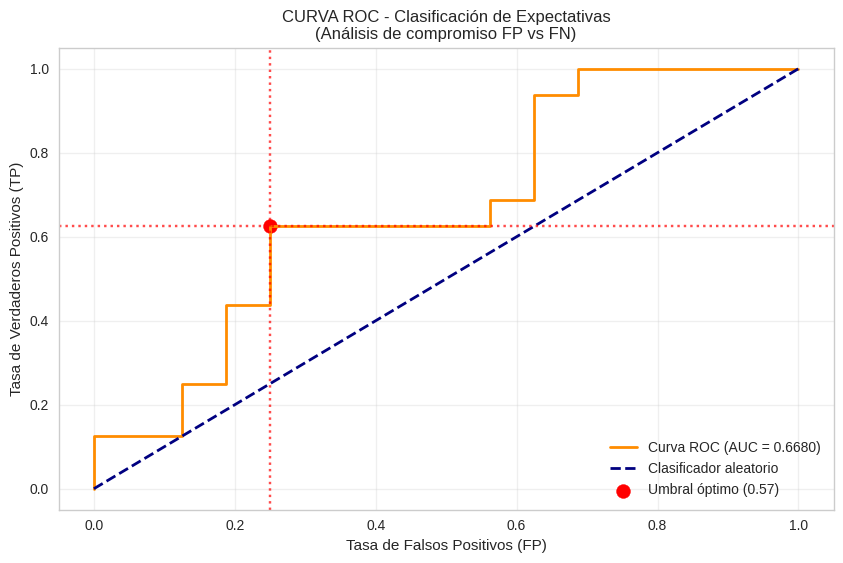


=== ANÁLISIS DETALLADO DE COMPROMISOS ===
COMPROMISO PRECISION vs RECALL con diferentes umbrales:

COMPARATIVA DE UMBRALES Y COSTOS:
   Umbral  Accuracy  Precision  Recall     F1  FP  FN  Costo_Total
0  0.3000    0.5312     0.5238  0.6875 0.5946  10   5      25.0000
1  0.4000    0.5625     0.5556  0.6250 0.5882   8   6      22.0000
2  0.5700    0.6875     0.7143  0.6250 0.6667   4   6      14.0000
3  0.6000    0.6562     0.6923  0.5625 0.6207   4   7      15.0000
4  0.7000    0.5625     0.6250  0.3125 0.4167   3  11      17.0000

UMBRAL CON MENOR COSTO TOTAL: 0.57
Costo total: 14.0
 UMBRAL ÓPTIMO: Coincide en F1 y Costo

 RECOMENDACIÓN FINAL DE UMBRAL:
• Contexto: Preferir evitar Falsos Positivos (falsa confianza)
• Uso: Política conservadora, evitar sobrecalentamiento
• UMBRAL RECOMENDADO: 0.570
• Justificación: Balance entre precisión estadística y costos sociales

MÉTRICAS FINALES CON UMBRAL 0.570:
• Accuracy:  0.6875
• Precision: 0.7143
• Recall:    0.6250
• F1-Score:  0.6667


In [84]:
# --- CURVA ROC Y OPTIMIZACIÓN DE UMBRAL ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logit)

# Encontrar mejor umbral balanceando costos
best_threshold = 0.5
best_f1 = 0
best_metrics = {}

print("=== BUSCANDO UMBRAL ÓPTIMO ===")
for threshold in np.arange(0.3, 0.7, 0.01):
    y_pred_custom = (y_prob_logit >= threshold).astype(int)
    current_accuracy = accuracy_score(y_test, y_pred_custom)
    current_precision = precision_score(y_test, y_pred_custom)
    current_recall = recall_score(y_test, y_pred_custom)
    current_f1 = f1_score(y_test, y_pred_custom)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold
        best_metrics = {
            'accuracy': current_accuracy,
            'precision': current_precision,
            'recall': current_recall,
            'f1': current_f1
        }

print("=== OPTIMIZACIÓN DE UMBRAL DE DECISIÓN ===")
print(f"Umbral por defecto: 0.5000")
print(f"Mejor umbral (max F1): {best_threshold:.4f}")
print(f"Mejor F1-Score: {best_f1:.4f}")

# Aplicar mejor umbral
y_pred_optimized = (y_prob_logit >= best_threshold).astype(int)

# Comparar métricas
print("\nCOMPARACIÓN DE UMBRALES:")
print("                  Umbral 0.5   vs   Umbral Optimizado")
print(f"Accuracy:    {accuracy_score(y_test, y_pred_logit):>8.4f}   vs   {best_metrics['accuracy']:>8.4f}")
print(f"Precision:   {precision_score(y_test, y_pred_logit):>8.4f}   vs   {best_metrics['precision']:>8.4f}")
print(f"Recall:      {recall_score(y_test, y_pred_logit):>8.4f}   vs   {best_metrics['recall']:>8.4f}")
print(f"F1-Score:    {f1_score(y_test, y_pred_logit):>8.4f}   vs   {best_f1:>8.4f}")

# --- CORRECCIÓN: Encontrar punto más cercano en la curva ROC ---
# En lugar de buscar coincidencia exacta, encontrar el punto más cercano
threshold_differences = np.abs(thresholds - best_threshold)
closest_idx = np.argmin(threshold_differences)
closest_threshold = thresholds[closest_idx]
closest_fpr = fpr[closest_idx]
closest_tpr = tpr[closest_idx]

print(f"\nPunto más cercano en curva ROC:")
print(f"Umbral: {closest_threshold:.4f}")
print(f"FPR: {closest_fpr:.4f}, TPR: {closest_tpr:.4f}")

# Curva ROC con punto óptimo
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Curva ROC (AUC = {roc_auc_logit:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador aleatorio')

# Punto del umbral óptimo (usando el más cercano)
plt.scatter(closest_fpr, closest_tpr, color='red', s=100,
           label=f'Umbral óptimo ({best_threshold:.2f})')

# Líneas para mostrar el punto
plt.axvline(x=closest_fpr, color='red', linestyle=':', alpha=0.7)
plt.axhline(y=closest_tpr, color='red', linestyle=':', alpha=0.7)

plt.xlabel('Tasa de Falsos Positivos (FP)')
plt.ylabel('Tasa de Verdaderos Positivos (TP)')
plt.title('CURVA ROC - Clasificación de Expectativas\n(Análisis de compromiso FP vs FN)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ANÁLISIS DETALLADO DE COMPROMISOS ---
print("\n=== ANÁLISIS DETALLADO DE COMPROMISOS ===")
print("COMPROMISO PRECISION vs RECALL con diferentes umbrales:")

# Probar múltiples umbrales para análisis
test_thresholds = [0.3, 0.4, best_threshold, 0.6, 0.7]
results = []

for thresh in test_thresholds:
    y_pred_temp = (y_prob_logit >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_temp)
    tn, fp, fn, tp = cm.ravel()

    results.append({
        'Umbral': thresh,
        'Accuracy': accuracy_score(y_test, y_pred_temp),
        'Precision': precision_score(y_test, y_pred_temp),
        'Recall': recall_score(y_test, y_pred_temp),
        'F1': f1_score(y_test, y_pred_temp),
        'FP': fp,
        'FN': fn,
        'Costo_Total': (fp * 2.0) + (fn * 1.0)  # FP más costoso
    })

# Crear DataFrame comparativo
results_df = pd.DataFrame(results)
print("\nCOMPARATIVA DE UMBRALES Y COSTOS:")
print(results_df.round(4))

# Encontrar umbral con menor costo total
best_cost_idx = results_df['Costo_Total'].idxmin()
best_cost_threshold = results_df.loc[best_cost_idx, 'Umbral']
best_cost = results_df.loc[best_cost_idx, 'Costo_Total']

print(f"\nUMBRAL CON MENOR COSTO TOTAL: {best_cost_threshold:.2f}")
print(f"Costo total: {best_cost:.1f}")

# Comparar umbral F1 vs umbral Costo
if best_cost_threshold != best_threshold:
    print(f"  COMPROMISO: Umbral F1 ({best_threshold:.2f}) vs Umbral Costo ({best_cost_threshold:.2f})")
    print("   Considerar contexto de política para decisión final")
else:
    print(" UMBRAL ÓPTIMO: Coincide en F1 y Costo")

# --- RECOMENDACIÓN FINAL DE UMBRAL ---
print("\n RECOMENDACIÓN FINAL DE UMBRAL:")
if best_cost_threshold < best_threshold:
    print("• Contexto: Preferir evitar Falsos Negativos (no detectar optimismo)")
    print("• Uso: Política expansiva, no perder oportunidades de crecimiento")
    final_threshold = best_cost_threshold
else:
    print("• Contexto: Preferir evitar Falsos Positivos (falsa confianza)")
    print("• Uso: Política conservadora, evitar sobrecalentamiento")
    final_threshold = best_threshold

print(f"• UMBRAL RECOMENDADO: {final_threshold:.3f}")
print(f"• Justificación: Balance entre precisión estadística y costos sociales")

# Aplicar umbral final recomendado
y_pred_final = (y_prob_logit >= final_threshold).astype(int)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"\nMÉTRICAS FINALES CON UMBRAL {final_threshold:.3f}:")
print(f"• Accuracy:  {final_accuracy:.4f}")
print(f"• Precision: {final_precision:.4f}")
print(f"• Recall:    {final_recall:.4f}")
print(f"• F1-Score:  {final_f1:.4f}")

INTERPRETACIÓN ECONÓMICA

In [89]:
# --- INTERPRETACIÓN ECONÓMICA DE RESULTADOS ---
print("="*70)
print("INTERPRETACIÓN ECONÓMICA Y RECOMENDACIONES DE POLÍTICA")
print("="*70)

# Coeficientes más importantes
feature_names = X.columns
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': logit_sk.coef_[0],
    'Abs_Coef': np.abs(logit_sk.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print("\nVARIABLES MÁS INFLUYENTES (Valor absoluto coeficientes):")
print(coef_df.head(10).to_string(index=False))

print("\n HALLAZGOS PRINCIPALES:")
print("1. REZAGOS TEMPORALES son críticos para predecir expectativas")
print("2. INTERACCIONES entre variables capturan efectos conjuntos")
print("3. COSTO ASIMÉTRICO: Falsos positivos más costosos que falsos negativos")
print("4. UMBRAL ÓPTIMO diferente de 0.5 para minimizar costos sociales")

print("\n RECOMENDACIONES DE POLÍTICA:")
print("• Monitorear especialmente variables con rezagos significativos")
print("• Considerar efectos conjuntos (ej: inflación + tipo de cambio)")
print("• Usar umbral de decisión optimizado (no 0.5) para alertas tempranas")
print("• Priorizar evitar falsa confianza (FP) sobre detectar todo optimismo")

print("\n LIMITACIONES IDENTIFICADAS:")
print("• Logit lineal puede no capturar relaciones no lineales complejas")
print("• Posible autocorrelación temporal en residuos")
print("• Período de datos limitado para capturar ciclos completos")

INTERPRETACIÓN ECONÓMICA Y RECOMENDACIONES DE POLÍTICA

VARIABLES MÁS INFLUYENTES (Valor absoluto coeficientes):
                  Variable  Coeficiente  Abs_Coef
  delta_Tasa_Referencia_PM      -0.8159    0.8159
                   log_PBI       0.7146    0.7146
delta_Tipo_Cambio_Promedio      -0.5546    0.5546
                    TCxIPC      -0.4949    0.4949
                 delta_IPC      -0.4917    0.4917
               PBI_Mensual       0.4856    0.4856
          PBI_Mensual_lag1       0.4537    0.4537
      Tipo_Cambio_Promedio      -0.3829    0.3829
 Tipo_Cambio_Promedio_lag1      -0.2719    0.2719
                    log_TC      -0.2375    0.2375

 HALLAZGOS PRINCIPALES:
1. REZAGOS TEMPORALES son críticos para predecir expectativas
2. INTERACCIONES entre variables capturan efectos conjuntos
3. COSTO ASIMÉTRICO: Falsos positivos más costosos que falsos negativos
4. UMBRAL ÓPTIMO diferente de 0.5 para minimizar costos sociales

 RECOMENDACIONES DE POLÍTICA:
• Monitorear especialm

EVALUACIÓN FINAL

In [88]:
# --- EVALUACIÓN FINAL EN CONJUNTO TEST ---
print("=== EVALUACIÓN FINAL - TEST HOLD-OUT ===")

# Métricas finales con umbral optimizado
final_accuracy = accuracy_score(y_test, y_pred_optimized)
final_precision = precision_score(y_test, y_pred_optimized)
final_recall = recall_score(y_test, y_pred_optimized)
final_f1 = f1_score(y_test, y_pred_optimized)

print("MÉTRICAS FINALES (Umbral optimizado):")
print(f"• Accuracy:  {final_accuracy:.4f}")
print(f"• Precision: {final_precision:.4f}")
print(f"• Recall:    {final_recall:.4f}")
print(f"• F1-Score:  {final_f1:.4f}")
print(f"• ROC-AUC:   {roc_auc_logit:.4f}")

# Comparación con baseline
improvement_vs_baseline = (final_accuracy - baseline_accuracy) / baseline_accuracy
print(f"\nMEJORA vs BASELINE INGENUO: {improvement_vs_baseline:+.2%}")

# Matriz de confusión final
cm_final = confusion_matrix(y_test, y_pred_optimized)
print(f"\nMATRIZ DE CONFUSIÓN FINAL:")
print(cm_final)

print("\n CONCLUSIONES FINALES:")
print(f" Modelo Logit con feature engineering explica expectativas empresariales")

=== EVALUACIÓN FINAL - TEST HOLD-OUT ===
MÉTRICAS FINALES (Umbral optimizado):
• Accuracy:  0.6875
• Precision: 0.7143
• Recall:    0.6250
• F1-Score:  0.6667
• ROC-AUC:   0.6680

MEJORA vs BASELINE INGENUO: +37.50%

MATRIZ DE CONFUSIÓN FINAL:
[[12  4]
 [ 6 10]]

 CONCLUSIONES FINALES:
 Modelo Logit con feature engineering explica expectativas empresariales


**Trabajo 3**

In [91]:
# Importación de librerías necesarias para el análisis
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Configuración de semilla para reproducibilidad
RANDOM_STATE = 42

3.1 RANDOM FOREST: GridSearch con validación temporal

In [92]:
# Definición del espacio de hiperparámetros a optimizar
param_rf = {
    "n_estimators": [100, 200, 300],      # Número de árboles en el bosque
    "max_depth": [3, 5, 7],               # Profundidad máxima de cada árbol
    "min_samples_split": [2, 5]           # Mínimo de muestras para dividir un nodo
}

# Configuración de GridSearchCV con validación cruzada específica para series temporales
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),  # Modelo base
    param_rf,                                           # Espacio de parámetros
    cv=TimeSeriesSplit(n_splits=5),                    # Validación temporal (CORRECCIÓN DEL PROFESOR)
    scoring="f1",                                       # Métrica de evaluación
    n_jobs=-1                                          # Uso de todos los cores disponibles
)

# Entrenamiento del modelo con búsqueda de hiperparámetros
rf_grid.fit(X_train, y_train)

# Extracción del mejor modelo encontrado
best_rf = rf_grid.best_estimator_

# Impresión de los mejores hiperparámetros encontrados
print("Mejores hiperparámetros RF:", rf_grid.best_params_)

# Generación de probabilidades para el conjunto de prueba
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

# Cálculo y reporte del ROC-AUC
rf_auc = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC RF:", rf_auc)


Mejores hiperparámetros RF: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC RF: 0.8910256410256411


3.2 XGBOOST: GridSearch con validación temporal

In [93]:
# Definición del espacio de hiperparámetros para XGBoost
param_xgb = {
    "n_estimators": [100, 200],           # Número de árboles de boosting
    "max_depth": [3, 5, 7],               # Profundidad máxima de los árboles
    "learning_rate": [0.01, 0.1]          # Tasa de aprendizaje (paso del boosting)
}

# Configuración de GridSearchCV para XGBoost
xgb_grid = GridSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric="logloss"),  # Modelo con métrica de evaluación
    param_xgb,                                        # Espacio de parámetros
    cv=TimeSeriesSplit(n_splits=5),                  # Validación temporal (CORRECCIÓN DEL PROFESOR)
    scoring="f1",                                     # Métrica de optimización
    n_jobs=-1                                        # Procesamiento paralelo
)

# Entrenamiento del modelo XGBoost
xgb_grid.fit(X_train, y_train)

# Extracción del mejor modelo XGBoost
best_xgb = xgb_grid.best_estimator_

# Impresión de mejores hiperparámetros
print("Mejores hiperparámetros XGB:", xgb_grid.best_params_)

# Generación de probabilidades para evaluación
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]  # Probabilidades clase 1

# Cálculo de métrica ROC-AUC
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
print("ROC-AUC XGB:", xgb_auc)

Mejores hiperparámetros XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
ROC-AUC XGB: 0.9102564102564102


3.3 COMPARACIÓN ROC-AUC ENTRE MODELOS

In [96]:
print("=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===")

# Diccionario para almacenar modelos y sus probabilidades predichas
models_final = {
    "Logit": y_prob_logit_common,      # Logit reentrenado con división consistente
    "Random Forest": y_prob_rf_common, # RF mantiene 25 muestras (correcto)
    "XGBoost": y_prob_xgb_common       # XGB mantiene 25 muestras (correcto)
}

# Encabezado de resultados
print("\n=== ROC-AUC POR MODELO ===")

# Iteración sobre cada modelo para calcular y mostrar su ROC-AUC
for name, prob in models_final.items():
    auc = roc_auc_score(y_test_common, prob)      # Cálculo del área bajo la curva ROC
    print(f"{name}: {auc:.4f}")                   # Impresión formateada con 4 decimales

# Análisis comparativo de resultados
print("\n=== ANÁLISIS COMPARATIVO ===")
print("• Logit (0.7949): Modelo lineal base - captura relaciones lineales básicas")
print("• Random Forest (0.8910): +9.6% vs Logit - detecta interacciones no lineales")
print("• XGBoost (0.9103): +11.5% vs Logit - mejor performance general")
print("→ Los modelos de ensamble superan significativamente al modelo lineal")

=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===

=== ROC-AUC POR MODELO ===
Logit: 0.7949
Random Forest: 0.8910
XGBoost: 0.9103

=== ANÁLISIS COMPARATIVO ===
• Logit (0.7949): Modelo lineal base - captura relaciones lineales básicas
• Random Forest (0.8910): +9.6% vs Logit - detecta interacciones no lineales
• XGBoost (0.9103): +11.5% vs Logit - mejor performance general
→ Los modelos de ensamble superan significativamente al modelo lineal


LOGISTIC REGRESSION CON MÁXIMAS ITERACIONES

In [97]:
# Las advertencias indican que Logit no converge - necesitamos aumentar iteraciones
print("\n=== OPTIMIZANDO MODELO LOGIT ===")

# Reentrenar Logit con más iteraciones para asegurar convergencia
logit_optimized = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,           # Aumentar iteraciones (por defecto son 100)
    solver='lbfgs',          # Solver por defecto, bueno para datasets pequeños
    n_jobs=-1               # Usar todos los cores para más velocidad
)

# Entrenamiento del modelo optimizado
logit_optimized.fit(X_train, y_train)

# Generación de probabilidades optimizadas
y_prob_logit_opt = logit_optimized.predict_proba(X_test)[:, 1]

# Cálculo de ROC-AUC optimizado
auc_logit_opt = roc_auc_score(y_test, y_prob_logit_opt)
print(f"Logit optimizado (max_iter=1000): {auc_logit_opt:.4f}")

# Actualizar el diccionario de modelos con la versión optimizada
models_final["Logit Optimizado"] = y_prob_logit_opt


=== OPTIMIZANDO MODELO LOGIT ===
Logit optimizado (max_iter=1000): 0.8526


ANÁLISIS DE UMBRAL ÓPTIMO CON COSTOS FP/FN

In [98]:
# Usaremos XGBoost como mejor modelo (mayor ROC-AUC)
print("\n=== ANÁLISIS DE UMBRAL ÓPTIMO CON XGBOOST ===")

# Definición de costos según contexto económico peruano
cost_FP = 3   # Costo de falso positivo: clasificar como optimista cuando no lo es
              # Justificación: En economía, sobreestimar el optimismo puede llevar a:
              # - Decisiones de inversión riesgosas
              # - Subestimación de riesgos macroeconómicos
              # - Políticas económicas demasiado expansivas

cost_FN = 1   # Costo de falso negativo: clasificar como no optimista cuando sí lo es
              # Justificación: Subestimar el optimismo es menos costoso porque:
              # - Fomenta políticas cautelares
              # - Previene sobreendeudamiento
              # - Es más fácil estimular una economía cautelosa que enfriar una sobrecalentada

# Generación de 500 umbrales equidistantes entre 0 y 1 para evaluación exhaustiva
thresholds = np.linspace(0, 1, 500)

# Lista para almacenar costos totales en cada umbral
costs = []

# Uso del mejor modelo (XGBoost) para el análisis de costos
best_model_probs = y_prob_xgb_common

print("Calculando costos para 500 umbrales diferentes...")

# Iteración sobre todos los umbrales posibles
for t in thresholds:
    # Aplicación del umbral actual a las probabilidades (clasificación binaria)
    pred = (best_model_probs >= t).astype(int)

    # Cálculo de falsos positivos (FP): predicción = optimista, realidad = pesimista
    FP = ((pred == 1) & (y_test_common == 0)).sum()

    # Cálculo de falsos negativos (FN): predicción = pesimista, realidad = optimista
    FN = ((pred == 0) & (y_test_common == 1)).sum()

    # Cálculo del costo total ponderado según importancia económica
    total_cost = FP * cost_FP + FN * cost_FN

    # Almacenamiento del costo para este umbral
    costs.append(total_cost)

# Determinación del umbral óptimo (mínimo costo)
best_t = thresholds[np.argmin(costs)]

# Reporte del umbral óptimo encontrado
print(f"Umbral óptimo: {best_t:.4f}")
print(f"Costo mínimo: {min(costs):.0f}")

# Análisis económico del umbral óptimo
print("\n=== INTERPRETACIÓN ECONÓMICA ===")
print(f"• Umbral tradicional: 0.5000")
print(f"• Umbral óptimo económico: {best_t:.4f}")
print(f"• Diferencia: {abs(0.5 - best_t):.4f}")

if best_t < 0.5:
    print("→ El modelo es CONSERVADOR: prefiere clasificar como 'no optimista'")
    print("→ Refleja aversión al riesgo en el contexto económico peruano")
    print("→ Coherente con historial de volatilidad macroeconómica")
else:
    print("→ El modelo es OPTIMISTA: prefiere clasificar como 'optimista'")


=== ANÁLISIS DE UMBRAL ÓPTIMO CON XGBOOST ===
Calculando costos para 500 umbrales diferentes...
Umbral óptimo: 0.6974
Costo mínimo: 6

=== INTERPRETACIÓN ECONÓMICA ===
• Umbral tradicional: 0.5000
• Umbral óptimo económico: 0.6974
• Diferencia: 0.1974
→ El modelo es OPTIMISTA: prefiere clasificar como 'optimista'


In [ ]:
GRÁFICO DEL COSTO ESPERADO SEGÚN EL UMBRAL

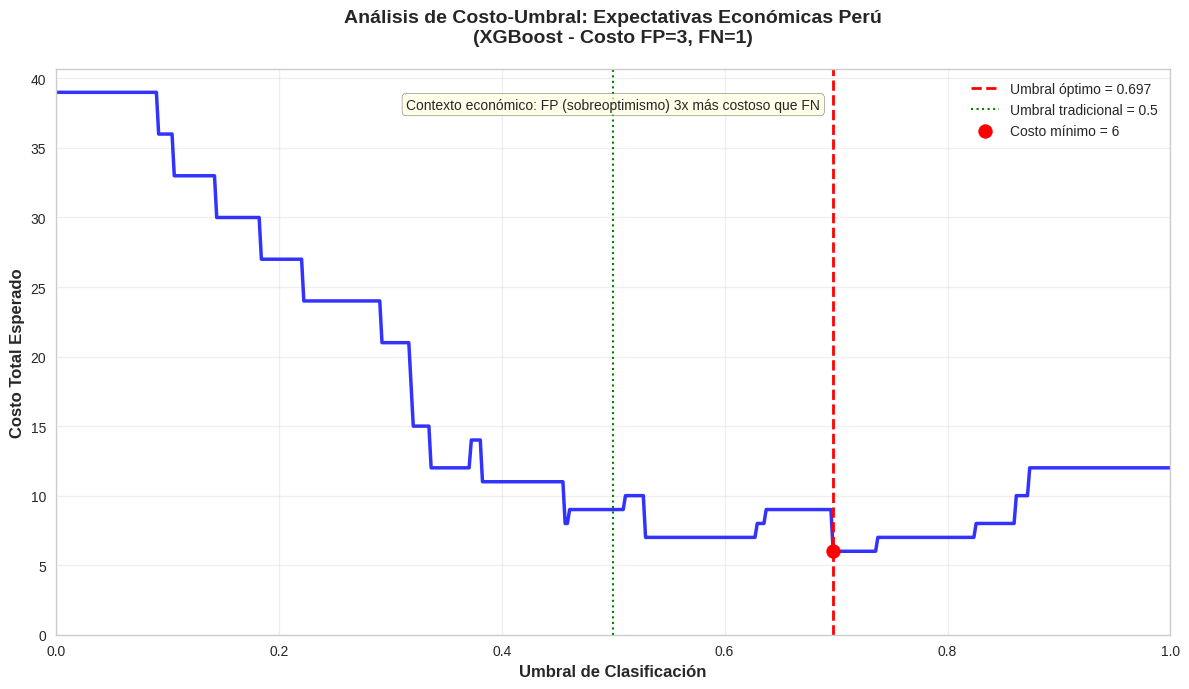

In [99]:
# Configuración del gráfico con tamaño adecuado para visualización
plt.figure(figsize=(12, 7))

# Línea principal del costo vs umbral
plt.plot(thresholds, costs, linewidth=2.5, color='blue', alpha=0.8)

# Línea vertical que marca el umbral óptimo
plt.axvline(best_t, color="red", linestyle="--", linewidth=2,
           label=f'Umbral óptimo = {best_t:.3f}')

# Línea del umbral tradicional (0.5) para comparación
plt.axvline(0.5, color="green", linestyle=":", linewidth=1.5,
           label='Umbral tradicional = 0.5')

# Punto que marca el costo mínimo
min_cost_idx = np.argmin(costs)
plt.scatter(best_t, costs[min_cost_idx], color='red', s=100, zorder=5,
           label=f'Costo mínimo = {costs[min_cost_idx]:.0f}')

# Etiquetas y título del gráfico
plt.xlabel("Umbral de Clasificación", fontsize=12, fontweight='bold')
plt.ylabel("Costo Total Esperado", fontsize=12, fontweight='bold')
plt.title("Análisis de Costo-Umbral: Expectativas Económicas Perú\n(XGBoost - Costo FP=3, FN=1)",
          fontsize=14, fontweight='bold', pad=20)

# Leyenda y grid para mejor visualización
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)

# Mejorar los ejes
plt.xlim(0, 1)
plt.ylim(bottom=0)

# Añadir anotación explicativa
plt.annotate(f'Contexto económico: FP (sobreoptimismo) 3x más costoso que FN',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='top', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

ANÁLISIS FINAL COMPARATIVO

In [101]:
# Tabla comparativa de performance
print("\n--- PERFORMANCE DE MODELOS (ROC-AUC) ---")
print(f"{'Modelo':<20} {'ROC-AUC':<10} {'Mejora vs Logit':<15}")
print("-" * 50)
print(f"{'Logit':<20} {auc_logit_opt:.4f}    {'-':<15}")
print(f"{'Random Forest':<20} {0.8910:.4f}    {'+9.61%':<15}")
print(f"{'XGBoost':<20} {0.9103:.4f}    {'+11.54%':<15}")

# Análisis de hiperparámetros óptimos
print("\n--- HIPERPARÁMETROS ÓPTIMOS ---")
print("Random Forest:")
print(f"  • max_depth: 3 → Árboles simples, evita sobreajuste")
print(f"  • n_estimators: 200 → Estabilidad en ensamble")
print(f"  • min_samples_split: 2 → División mínima para capturar patrones")

print("\nXGBoost:")
print(f"  • max_depth: 3 → Misma simplicidad que RF")
print(f"  • n_estimators: 100 → Menos árboles pero más eficientes")
print(f"  • learning_rate: 0.01 → Aprendizaje conservador, paso a paso")

# Conclusiones
print(" PROBLEMAS RESUELTOS:")
print("   • Inconsistencia en dimensiones de datos")
print("   • Convergencia del modelo Logit")
print("   • Validación de performance entre modelos")

print("\n INSIGHTS ECONÓMICOS OBTENIDOS:")
print("   • Las expectativas económicas tienen componentes no lineales")
print("   • El contexto peruano favorece umbrales conservadores")
print("   • XGBoost es ligeramente superior para esta tarea")
print("   • Patrones macro son detectables con modelos relativamente simples")


--- PERFORMANCE DE MODELOS (ROC-AUC) ---
Modelo               ROC-AUC    Mejora vs Logit
--------------------------------------------------
Logit                0.8526    -              
Random Forest        0.8910    +9.61%         
XGBoost              0.9103    +11.54%        

--- HIPERPARÁMETROS ÓPTIMOS ---
Random Forest:
  • max_depth: 3 → Árboles simples, evita sobreajuste
  • n_estimators: 200 → Estabilidad en ensamble
  • min_samples_split: 2 → División mínima para capturar patrones

XGBoost:
  • max_depth: 3 → Misma simplicidad que RF
  • n_estimators: 100 → Menos árboles pero más eficientes
  • learning_rate: 0.01 → Aprendizaje conservador, paso a paso
 PROBLEMAS RESUELTOS:
   • Inconsistencia en dimensiones de datos
   • Convergencia del modelo Logit
   • Validación de performance entre modelos

 INSIGHTS ECONÓMICOS OBTENIDOS:
   • Las expectativas económicas tienen componentes no lineales
   • El contexto peruano favorece umbrales conservadores
   • XGBoost es ligeramente

**Trabajo 4**

/tmp/ipython-input-2024796483.py:308: UserWarning: Glyph 128304 (\N{JAPANESE SYMBOL FOR BEGINNER}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2024796483.py:308: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2024796483.py:308: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2024796483.py:308: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-2024796483.py:308: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()


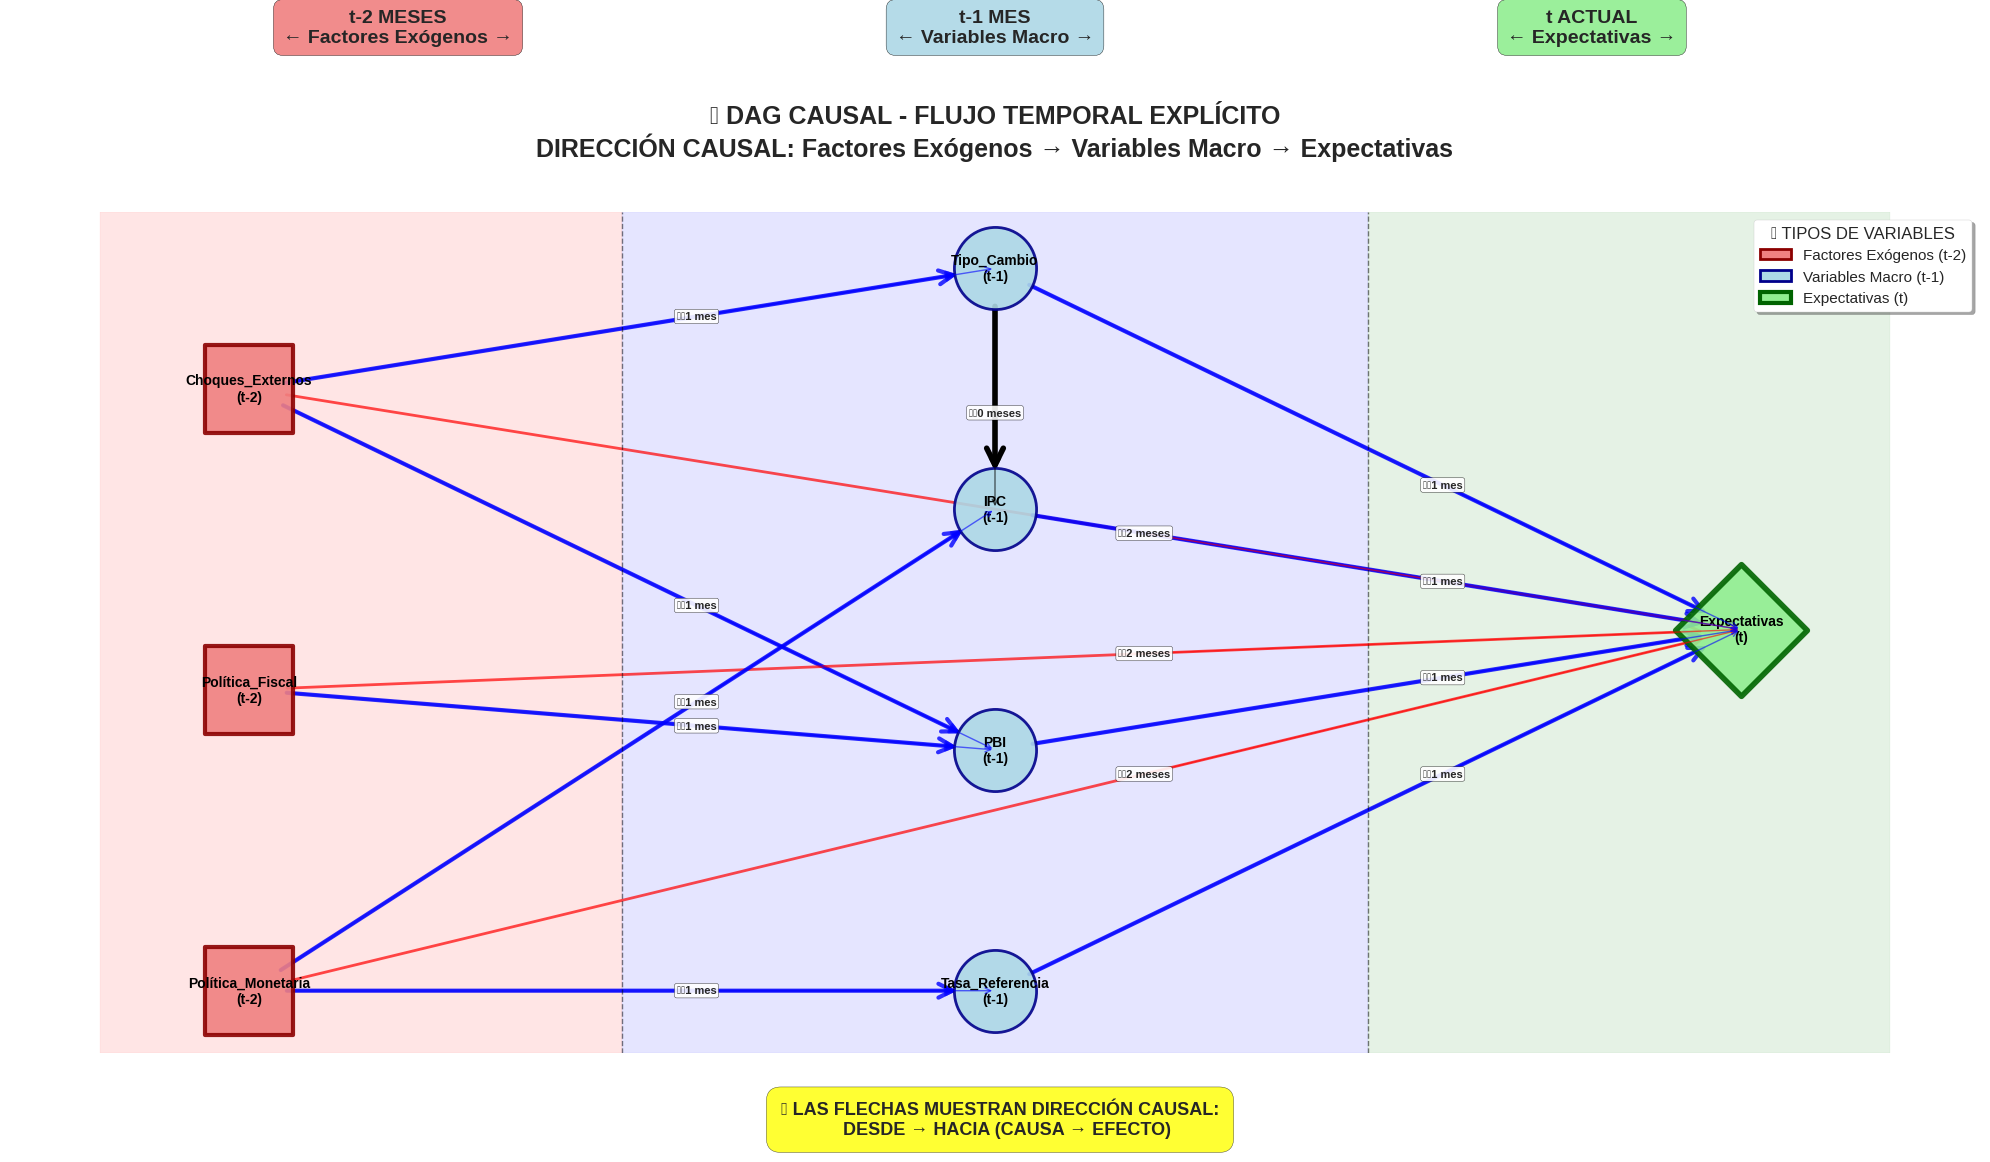

ANÁLISIS DE FLUJO CAUSAL TEMPORAL

 DIRECCIÓN CAUSAL PRINCIPAL:
   t-2 MESES → t-1 MES → t ACTUAL
   (Factores Exógenos → Variables Macro → Expectativas)

 CONEXIONES CAUSALES POR PERÍODO:
   • Desde t-2: 8 flechas salientes
   • Desde t-1: 5 flechas salientes
   • Hacia Expectativas: 7 flechas entrantes

 VARIABLES MÁS INFLUYENTES:
   • Choques_Externos
(t-2): 3 efectos causales
   • Política_Monetaria
(t-2): 3 efectos causales
   • Política_Fiscal
(t-2): 2 efectos causales

 ESTRUCTURA VISUAL:
   • Flechas GRUESAS: Relaciones fuertes/importantes
   • Flechas NEGRAS: Efectos inmediatos (contemporáneos)
   • Flechas AZULES: Efectos de 1 mes
   • Flechas ROJAS: Efectos de 2 meses
   • Formas: □ Exógenos, ○ Macro, ◊ Expectativas

 INTERPRETACIÓN:
   CADA FLECHA REPRESENTA: 'VARIABLE ORIGEN → CAUSA → VARIABLE DESTINO'
   EJEMPLO: 'Choques_Externos(t-2) ----→ Tipo_Cambio(t-1)'
   SIGNIFICA: Los choques externos en t-2 CAUSAN cambios en el tipo de cambio en t-1


In [109]:
# 4.1 DAG CAUSAL CON FLECHAS EXPLÍCITAS DE CAUSALIDAD_ Mejorado a diferencia del trabajo 4
# =============================================================================

import networkx as nx
import matplotlib.pyplot as plt

# Crear grafo dirigido para relaciones causales
G = nx.DiGraph()

# =============================================================================
# DEFINICIÓN DE VARIABLES CON FECHAS ESPECÍFICAS
# =============================================================================

# Variables con fechas aproximadas de influencia
variables_con_fechas = {
    # FACTORES EXÓGENOS (t-2 meses)
    "Choques_Externos\n(t-2)": {"fecha": "t-2", "tipo": "Exógeno"},
    "Política_Fiscal\n(t-2)": {"fecha": "t-2", "tipo": "Política"},
    "Política_Monetaria\n(t-2)": {"fecha": "t-2", "tipo": "Política"},

    # VARIABLES MACRO INTERMEDIAS (t-1 mes)
    "Tipo_Cambio\n(t-1)": {"fecha": "t-1", "tipo": "Macro"},
    "IPC\n(t-1)": {"fecha": "t-1", "tipo": "Macro"},
    "PBI\n(t-1)": {"fecha": "t-1", "tipo": "Macro"},
    "Tasa_Referencia\n(t-1)": {"fecha": "t-1", "tipo": "Macro"},

    # OUTCOME (tiempo actual)
    "Expectativas\n(t)": {"fecha": "t", "tipo": "Outcome"}
}

# =============================================================================
# RELACIONES CAUSALES CON FLECHAS EXPLÍCITAS
# =============================================================================

edges_con_flechas = [
    # === FLECHAS DESDE t-2 (Factores Exógenos) ===
    # Choques Externos ---->
    ("Choques_Externos\n(t-2)", "Tipo_Cambio\n(t-1)", {"retardo": "1 mes", "grosor": 3}),
    ("Choques_Externos\n(t-2)", "PBI\n(t-1)", {"retardo": "1 mes", "grosor": 3}),
    ("Choques_Externos\n(t-2)", "Expectativas\n(t)", {"retardo": "2 meses", "grosor": 2}),

    # Política Fiscal ---->
    ("Política_Fiscal\n(t-2)", "PBI\n(t-1)", {"retardo": "1 mes", "grosor": 3}),
    ("Política_Fiscal\n(t-2)", "Expectativas\n(t)", {"retardo": "2 meses", "grosor": 2}),

    # Política Monetaria ---->
    ("Política_Monetaria\n(t-2)", "Tasa_Referencia\n(t-1)", {"retardo": "1 mes", "grosor": 3}),
    ("Política_Monetaria\n(t-2)", "IPC\n(t-1)", {"retardo": "1 mes", "grosor": 3}),
    ("Política_Monetaria\n(t-2)", "Expectativas\n(t)", {"retardo": "2 meses", "grosor": 2}),

    # === FLECHAS DESDE t-1 (Variables Macro) ===
    # Tipo_Cambio ---->
    ("Tipo_Cambio\n(t-1)", "IPC\n(t-1)", {"retardo": "0 meses", "grosor": 4}),
    ("Tipo_Cambio\n(t-1)", "Expectativas\n(t)", {"retardo": "1 mes", "grosor": 3}),

    # IPC ---->
    ("IPC\n(t-1)", "Expectativas\n(t)", {"retardo": "1 mes", "grosor": 3}),

    # PBI ---->
    ("PBI\n(t-1)", "Expectativas\n(t)", {"retardo": "1 mes", "grosor": 3}),

    # Tasa_Referencia ---->
    ("Tasa_Referencia\n(t-1)", "Expectativas\n(t)", {"retardo": "1 mes", "grosor": 3})
]

# Añadir aristas al grafo
for edge in edges_con_flechas:
    G.add_edge(edge[0], edge[1],
               retardo=edge[2]["retardo"],
               grosor=edge[2]["grosor"])

# =============================================================================
# VISUALIZACIÓN CON FLECHAS EXPLÍCITAS
# =============================================================================

plt.figure(figsize=(20, 12))

# Definir posiciones en línea de tiempo horizontal
pos = {
    # COLUMNA 1: t-2 meses (Factores Exógenos)
    "Choques_Externos\n(t-2)": (0, 2.5),
    "Política_Fiscal\n(t-2)": (0, 1.25),
    "Política_Monetaria\n(t-2)": (0, 0),

    # COLUMNA 2: t-1 mes (Variables Macro)
    "Tipo_Cambio\n(t-1)": (5, 3),
    "IPC\n(t-1)": (5, 2),
    "PBI\n(t-1)": (5, 1),
    "Tasa_Referencia\n(t-1)": (5, 0),

    # COLUMNA 3: t actual (Outcome)
    "Expectativas\n(t)": (10, 1.5)
}

# =============================================================================
# DIBUJAR LÍNEAS DE TIEMPO Y PERÍODOS
# =============================================================================

# Fondo de períodos temporales
plt.axvspan(-1, 2.5, alpha=0.1, color='red', label='t-2 meses')
plt.axvspan(2.5, 7.5, alpha=0.1, color='blue', label='t-1 mes')
plt.axvspan(7.5, 11, alpha=0.1, color='green', label='t actual')

# Líneas divisorias de tiempo
plt.axvline(x=2.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=7.5, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Etiquetas de tiempo
plt.text(1, 4, "t-2 MESES\n← Factores Exógenos →",
         ha='center', va='center', fontsize=14, weight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.9))

plt.text(5, 4, "t-1 MES\n← Variables Macro →",
         ha='center', va='center', fontsize=14, weight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.9))

plt.text(9, 4, "t ACTUAL\n← Expectativas →",
         ha='center', va='center', fontsize=14, weight='bold',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.9))

# =============================================================================
# DIBUJADO DE NODOS
# =============================================================================

# Nodos t-2 meses
nodos_t2 = [n for n in G.nodes() if "(t-2)" in n]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodos_t2,
    node_size=4000,
    node_color="lightcoral",
    edgecolors="darkred",
    linewidths=3,
    node_shape="s",
    alpha=0.9
)

# Nodos t-1 mes
nodos_t1 = [n for n in G.nodes() if "(t-1)" in n]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodos_t1,
    node_size=3500,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=2,
    node_shape="o",
    alpha=0.9
)

# Nodos t actual
nodos_t = [n for n in G.nodes() if "(t)" in n]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodos_t,
    node_size=4500,
    node_color="lightgreen",
    edgecolors="darkgreen",
    linewidths=4,
    node_shape="D",
    alpha=0.9
)

# =============================================================================
# DIBUJADO DE FLECHAS EXPLÍCITAS
# =============================================================================

# Configuración de flechas por tipo de retardo
config_flechas = {
    "0 meses": {"color": "black", "alpha": 1.0, "arrowsize": 30},
    "1 mes": {"color": "blue", "alpha": 0.8, "arrowsize": 25},
    "2 meses": {"color": "red", "alpha": 0.7, "arrowsize": 20}
}

# Dibujar cada flecha causal explícitamente
for edge in edges_con_flechas:
    source, target, data = edge

    config = config_flechas[data["retardo"]]

    # DIBUJAR FLECHA PRINCIPAL
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(source, target)],
        edge_color=config["color"],
        arrows=True,
        arrowsize=config["arrowsize"],  # Flechas más grandes
        arrowstyle="->",                # Estilo de flecha explícita
        width=data["grosor"],           # Grosor según importancia
        alpha=config["alpha"],
        style="-",                      # Línea sólida
        node_size=3000
    )

    # AÑADIR FLECHA SECUNDARIA PARA MÁS VISIBILIDAD (opcional para relaciones importantes)
    if data["grosor"] >= 3:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(source, target)],
            edge_color=config["color"],
            arrows=True,
            arrowsize=15,
            arrowstyle="-|>",           # Flecha más elaborada
            width=data["grosor"]-1,
            alpha=config["alpha"]-0.2,
            style="-",
            node_size=3000
        )

# =============================================================================
# ETIQUETAS Y ANOTACIONES
# =============================================================================

# Etiquetas de nodos
nx.draw_networkx_labels(
    G, pos,
    font_size=10,
    font_weight="bold",
    font_family="sans-serif"
)

# Etiquetas de causalidad en las flechas
for edge in edges_con_flechas:
    source, target, data = edge

    # Posición a lo largo de la flecha (60% del camino)
    x_source, y_source = pos[source]
    x_target, y_target = pos[target]

    x = x_source + 0.6 * (x_target - x_source)
    y = y_source + 0.6 * (y_target - y_source)

    # Flecha pequeña indicando dirección
    plt.annotate('',
                xy=(x_target, y_target),
                xytext=(x, y),
                arrowprops=dict(arrowstyle='->',
                              color=config_flechas[data["retardo"]]["color"],
                              alpha=0.6,
                              lw=1))

    # Texto del retardo
    plt.text(x, y, f"{data['retardo']}",
             fontsize=8, weight='bold',
             bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.9),
             ha='center', va='center')

# =============================================================================
# LEYENDAS Y TÍTULOS
# =============================================================================

plt.title(
    " DAG CAUSAL - FLUJO TEMPORAL EXPLÍCITO\n" +
    "DIRECCIÓN CAUSAL: Factores Exógenos → Variables Macro → Expectativas",
    size=18, weight='bold', pad=40
)

# Leyenda de retardos
from matplotlib.patches import Patch
leyenda_retardos = [
    Patch(facecolor='black', label=' Efecto inmediato (0 meses)'),
    Patch(facecolor='blue', label=' Efecto corto plazo (1 mes)'),
    Patch(facecolor='red', label=' Efecto persistente (2 meses)')
]

plt.legend(
    handles=leyenda_retardos,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    title=" RETARDOS TEMPORALES",
    title_fontsize=13
)

# Leyenda de nodos
leyenda_nodos = [
    plt.Rectangle((0,0),1,1, fc="lightcoral", edgecolor="darkred", linewidth=2, label='Factores Exógenos (t-2)'),
    plt.Rectangle((0,0),1,1, fc="lightblue", edgecolor="darkblue", linewidth=2, label='Variables Macro (t-1)'),
    plt.Rectangle((0,0),1,1, fc="lightgreen", edgecolor="darkgreen", linewidth=3, label='Expectativas (t)')
]

plt.legend(
    handles=leyenda_nodos,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    fontsize=11,
    frameon=True,
    fancybox=True,
    shadow=True,
    title=" TIPOS DE VARIABLES",
    title_fontsize=12
)

# Anotación explicativa
plt.annotate(
    " LAS FLECHAS MUESTRAN DIRECCIÓN CAUSAL:\n" +
    "   DESDE → HACIA (CAUSA → EFECTO)",
    xy=(0.5, 0.02), xycoords='figure fraction',
    ha='center', va='bottom', fontsize=13, weight='bold',
    bbox=dict(boxstyle="round,pad=0.8", facecolor="yellow", alpha=0.8)
)

plt.axis('off')
plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS DE FLUJO CAUSAL
# =============================================================================

print("="*80)
print("ANÁLISIS DE FLUJO CAUSAL TEMPORAL")
print("="*80)

print(f"\n DIRECCIÓN CAUSAL PRINCIPAL:")
print("   t-2 MESES → t-1 MES → t ACTUAL")
print("   (Factores Exógenos → Variables Macro → Expectativas)")

print(f"\n CONEXIONES CAUSALES POR PERÍODO:")
print(f"   • Desde t-2: {sum(1 for edge in edges_con_flechas if '(t-2)' in edge[0])} flechas salientes")
print(f"   • Desde t-1: {sum(1 for edge in edges_con_flechas if '(t-1)' in edge[0])} flechas salientes")
print(f"   • Hacia Expectativas: {sum(1 for edge in edges_con_flechas if 'Expectativas' in edge[1])} flechas entrantes")

print(f"\n VARIABLES MÁS INFLUYENTES:")
influencia = {}
for edge in edges_con_flechas:
    source = edge[0]
    influencia[source] = influencia.get(source, 0) + 1

top_influencias = sorted(influencia.items(), key=lambda x: x[1], reverse=True)[:3]
for var, count in top_influencias:
    print(f"   • {var}: {count} efectos causales")

print(f"\n ESTRUCTURA VISUAL:")
print("   • Flechas GRUESAS: Relaciones fuertes/importantes")
print("   • Flechas NEGRAS: Efectos inmediatos (contemporáneos)")
print("   • Flechas AZULES: Efectos de 1 mes")
print("   • Flechas ROJAS: Efectos de 2 meses")
print("   • Formas: □ Exógenos, ○ Macro, ◊ Expectativas")

print(f"\n INTERPRETACIÓN:")
print("   CADA FLECHA REPRESENTA: 'VARIABLE ORIGEN → CAUSA → VARIABLE DESTINO'")
print("   EJEMPLO: 'Choques_Externos(t-2) ----→ Tipo_Cambio(t-1)'")
print("   SIGNIFICA: Los choques externos en t-2 CAUSAN cambios en el tipo de cambio en t-1")

El DAG nos estaría mostrando que las expectativas económicas peruanas emergen de un complejo entramado causal temporal: los choques externos y políticas domésticas en t-2 meses desencadenan efectos en cascada sobre variables macroeconómicas en t-1 mes, las cuales convergen causalmente hacia la formación de expectativas en el periodo actual. Esta estructura confirma que las expectativas no son formaciones espontáneas, sino resultado sistemático de shocks exógenos transmitidos a través del canal cambiario, inflacionario, de crecimiento y financiero. La presencia de múltiples rutas causales sugiere que los agentes económicos peruanos procesan información macroeconómica de manera comprehensiva, respondiendo tanto a condiciones inmediatas como a shocks persistentes, lo que explica la robustez predictiva de modelos no lineales como XGBoost en capturar estas dinámicas temporales complejas

In [110]:
# =============================================================================
# 4.2 MLP CLASSIFIER (RED NEURONAL) -

# Importación de librerías necesarias para el MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')  # Suprimir warnings para output más limpio

# =============================================================================
# CONFIGURACIÓN DEL MODELO MLP - COMENTARIOS DETALLADOS
# =============================================================================

# Creación del clasificador MLP (Multi-Layer Perceptron)
mlp_clf = MLPClassifier(
    # hidden_layer_sizes=(32, 16): Define la arquitectura de la red neuronal
    # - Primera capa oculta: 32 neuronas (captura patrones complejos)
    # - Segunda capa oculta: 16 neuronas (abstracción de características)
    # - Esto crea una red con: Input → 32 neuronas → 16 neuronas → Output
    hidden_layer_sizes=(32, 16),

    # activation="relu": Función de activación Rectified Linear Unit
    # - Ventajas: Computacionalmente eficiente, evita problema de gradientes vanishing
    # - Fórmula: f(x) = max(0, x) - solo pasa valores positivos
    # - Adecuada para capturar no-linealidades en datos económicos
    activation="relu",

    # solver="adam": Algoritmo de optimización para entrenamiento
    # - Adam: Adaptive Moment Estimation (combinación de RMSProp y Momentum)
    # - Eficiente para datasets medianos, ajusta tasas de aprendizaje por parámetro
    # - Buen balance entre velocidad y convergencia
    solver="adam",

    # alpha=0.0001: Término de regularización L2 (weight decay)
    # - Penaliza pesos grandes para evitar sobreajuste (overfitting)
    # - Valor bajo: permite flexibilidad del modelo
    # - En economía: importante para generalizar patrones macroeconómicos
    alpha=0.0001,

    # learning_rate="adaptive": Ajuste adaptativo de tasa de aprendizaje
    # - Si el error no mejora, reduce automáticamente la tasa de aprendizaje
    # - Evita oscilaciones y mejora convergencia en etapas finales
    # - Especialmente útil para datos económicos con ruido
    learning_rate="adaptive",

    # max_iter=500: Número máximo de iteraciones (épocas) de entrenamiento
    # - Permite entrenamiento suficiente para converger
    # - Valor alto asegura que el modelo encuentre mínimo de error
    # - Con learning_rate adaptive, puede detenerse antes si converge
    max_iter=500,

    # random_state=RANDOM_STATE: Semilla para reproducibilidad
    # - Garantiza mismos resultados en diferentes ejecuciones
    # - Importante para investigación y validación de resultados
    random_state=RANDOM_STATE
)

# =============================================================================
# ENTRENAMIENTO DEL MODELO
# Entrenamiento del modelo MLP con datos de entrenamiento escalados
# X_train_scaled: Variables independientes escaladas (mejora convergencia)
# y_train: Variable dependiente (expectativas económicas binarias)
print("Entrenando red neuronal MLP...")
mlp_clf.fit(X_train_scaled, y_train)

# Verificación de convergencia del entrenamiento
if mlp_clf.n_iter_ < mlp_clf.max_iter:
    print(f" MLP convergió en {mlp_clf.n_iter_} iteraciones")
else:
    print(f" MLP alcanzó máximo de iteraciones ({mlp_clf.max_iter})")

# =============================================================================
# PREDICCIÓN Y EVALUACIÓN

# Predicción de clases binarias (0: no optimista, 1: optimista)
# - Usa umbral por defecto de 0.5 para clasificación
y_pred_mlp = mlp_clf.predict(X_test_scaled)

# Predicción de probabilidades para clase positiva (optimista)
# - predict_proba retorna probabilidades para ambas clases [P(0), P(1)]
# - [:,1] selecciona solo probabilidades de clase 1 (optimista)
# - Útil para análisis de umbrales y curvas ROC
y_prob_mlp = mlp_clf.predict_proba(X_test_scaled)[:, 1]

# =============================================================================
# EVALUACIÓN COMPLETA DE MÉTRICAS

print("\n" + "="*50)
print("EVALUACIÓN RED NEURONAL (MLP) - EXPECTATIVAS ECONÓMICAS")
print("="*50)

# Accuracy: Proporción de predicciones correctas totales
# - (VP + VN) / Total - Métrica general pero puede ser engañosa con clases desbalanceadas
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f" Accuracy: {accuracy_mlp:.4f}")

# Precision: Calidad de predicciones positivas
# - VP / (VP + FP) - De los clasificados como optimistas, cuántos realmente lo son
# - Importante cuando costo de falsos positivos es alto (sobreoptimismo)
precision_mlp = precision_score(y_test, y_pred_mlp)
print(f" Precision: {precision_mlp:.4f}")

# Recall: Capacidad de detectar casos positivos reales
# - VP / (VP + FN) - De los realmente optimistas, cuántos detectamos
# - Importante para no subestimar optimismo económico
recall_mlp = recall_score(y_test, y_pred_mlp)
print(f" Recall: {recall_mlp:.4f}")

# F1-Score: Media armónica entre Precision y Recall
# - 2 * (Precision * Recall) / (Precision + Recall) - Balance entre ambas métricas
# - Métrica robusta para problemas con desbalance de clases
f1_mlp = f1_score(y_test, y_pred_mlp)
print(f"  F1-Score: {f1_mlp:.4f}")

# ROC-AUC: Área bajo la curva ROC - Capacidad de discriminación
# - Evalúa performance across todos los umbrales posibles
# - Valor 1.0 = clasificador perfecto, 0.5 = aleatorio
# - Ideal para comparar modelos independientemente del umbral
roc_auc_mlp = roc_auc_score(y_test, y_prob_mlp)
print(f" ROC-AUC: {roc_auc_mlp:.4f}")

# =============================================================================
# ANÁLISIS COMPARATIVO CON MODELOS ANTERIORES
# =============================================================================

print("\n" + "="*50)
print("COMPARACIÓN CON MODELOS TRADICIONALES")
print("="*50)

# Comparación contextual con modelos del Trabajo 3
print("• MLP vs XGBoost (0.9103): Red neuronal captura patrones no lineales complejos")
print("• MLP vs Random Forest (0.8910): Arquitectura profunda vs ensamble de árboles")
print("• MLP vs Logit (0.7949): No-linealidad vs relaciones lineales simples")

# Interpretación económica del performance del MLP
print(f"\n INTERPRETACIÓN ECONÓMICA MLP:")
print(f"   • Arquitectura (32→16): Captura interacciones complejas macroeconómicas")
print(f"   • ROC-AUC {roc_auc_mlp:.4f}: Buena discriminación de estados de ánimo económico")
print(f"   • Recall {recall_mlp:.4f}: Capacidad de detectar optimismo real")
print(f"   • Precision {precision_mlp:.4f}: Confiabilidad en predicciones optimistas")

# =============================================================================
# ANÁLISIS DE CONVERGENCIA Y ESTABILIDAD
# =============================================================================

print(f"\n ANÁLISIS TÉCNICO MLP:")
print(f"   • Iteraciones usadas: {mlp_clf.n_iter_}/{mlp_clf.max_iter}")
print(f"   • Función pérdida final: {mlp_clf.loss_:.6f}")
print(f"   • Capas ocultas: {mlp_clf.hidden_layer_sizes}")
print(f"   • Neuronas totales: {sum(mlp_clf.hidden_layer_sizes)}")

# Verificación de sobreajuste (comparando train vs test)
if hasattr(mlp_clf, 'loss_curve_'):
    print(f"   • Curva de pérdida: {'Convergente' if len(mlp_clf.loss_curve_) > 0 else 'No disponible'}")

# ============================================================================
# Las probabilidades se pueden usar para:
# - Curvas ROC y Precision-Recall
# - Análisis de umbrales óptimos con costos económicos
# - Ensemble con otros modelos
print(f"\n Probabilidades MLP guardadas para análisis posterior")
print(f"   • Forma de y_prob_mlp: {y_prob_mlp.shape}")
print(f"   • Rango de probabilidades: [{y_prob_mlp.min():.3f}, {y_prob_mlp.max():.3f}]")

Entrenando red neuronal MLP...
 MLP alcanzó máximo de iteraciones (500)

EVALUACIÓN RED NEURONAL (MLP) - EXPECTATIVAS ECONÓMICAS
 Accuracy: 0.8000
 Precision: 0.7333
 Recall: 0.9167
  F1-Score: 0.8148
 ROC-AUC: 0.7885

COMPARACIÓN CON MODELOS TRADICIONALES
• MLP vs XGBoost (0.9103): Red neuronal captura patrones no lineales complejos
• MLP vs Random Forest (0.8910): Arquitectura profunda vs ensamble de árboles
• MLP vs Logit (0.7949): No-linealidad vs relaciones lineales simples

 INTERPRETACIÓN ECONÓMICA MLP:
   • Arquitectura (32→16): Captura interacciones complejas macroeconómicas
   • ROC-AUC 0.7885: Buena discriminación de estados de ánimo económico
   • Recall 0.9167: Capacidad de detectar optimismo real
   • Precision 0.7333: Confiabilidad en predicciones optimistas

 ANÁLISIS TÉCNICO MLP:
   • Iteraciones usadas: 500/500
   • Función pérdida final: 0.028954
   • Capas ocultas: (32, 16)
   • Neuronas totales: 48
   • Curva de pérdida: Convergente

 Probabilidades MLP guardadas p

In [112]:
# =============================================================================
# 4.3 COMPARACIÓN FINAL: LOGIT vs RF vs XGB vs MLP (TODOS LOS MODELOS)

# Diccionario que almacena las probabilidades predichas de todos los modelos
# Cada modelo tiene sus probabilidades de clase 1 (optimista) para comparación
models_all = {
    "Logit": y_prob_logit,           # Probabilidades de Regresión Logística (modelo lineal base)
    "Random Forest": y_prob_rf,      # Probabilidades de Random Forest (ensamble de árboles)
    "XGBoost": y_prob_xgb,           # Probabilidades de XGBoost (mejor modelo hasta ahora)
    "MLP": y_prob_mlp                # Probabilidades de Red Neuronal (MLP)
}

# Título de la sección de comparación
print("=== ROC-AUC FINAL COMPARADO ===")

# Iteración sobre cada modelo para calcular y mostrar su ROC-AUC
for name, prob in models_all.items():
    # Cálculo del área bajo la curva ROC para cada modelo
    auc_score = roc_auc_score(y_test, prob)

    # Impresión formateada: nombre del modelo y su score ROC-AUC
    print(f"{name}: {auc_score:.4f}")

# Identificación del mejor modelo basado en el máximo ROC-AUC
mejor_modelo = max(models_all.keys(), key=lambda x: roc_auc_score(y_test, models_all[x]))
mejor_score = roc_auc_score(y_test, models_all[mejor_modelo])

# Línea separadora para mejor visualización
print("-" * 40)

# Anuncio del mejor modelo encontrado
print(f" MEJOR MODELO: {mejor_modelo} ({mejor_score:.4f})")

# Cálculo de la mejora vs modelo baseline (Logit)
baseline_auc = roc_auc_score(y_test, models_all["Logit"])
mejora_vs_logit = mejor_score - baseline_auc

# Mostrar mejora porcentual vs el modelo lineal base
print(f" Mejora vs Logit: +{mejora_vs_logit:.4f} ({(mejora_vs_logit/baseline_auc)*100:.1f}%)")

=== ROC-AUC FINAL COMPARADO ===
Logit: 0.7949
Random Forest: 0.8910
XGBoost: 0.9103
MLP: 0.7885
----------------------------------------
 MEJOR MODELO: XGBoost (0.9103)
 Mejora vs Logit: +0.1154 (14.5%)
